In [1]:
# Install necessary libraries
!pip install -q ultralytics imutils

In [2]:
import os
import cv2
import math
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from ultralytics import YOLO
import yaml


BASE_DIR = '/home/adityab/ADRL/A1/hit-uav'
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR, 'images/train')
TRAIN_LABELS_DIR = os.path.join(BASE_DIR, 'labels/train')
VAL_IMAGES_DIR = os.path.join(BASE_DIR, 'images/val')
VAL_LABELS_DIR = os.path.join(BASE_DIR, 'labels/val')
TEST_IMAGES_DIR = os.path.join(BASE_DIR, 'images/test')
TEST_LABELS_DIR = os.path.join(BASE_DIR, 'labels/test')


CLASS_NAMES = ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
CLASS_COLORS = np.random.uniform(0, 255, size=(len(CLASS_NAMES), 3))


def convert_yolo_to_bbox(box):
    cx, cy, w, h = box
    xmin = cx - w / 2
    ymin = cy - h / 2
    xmax = cx + w / 2
    ymax = cy + h / 2
    return xmin, ymin, xmax, ymax


def draw_boxes(img, bboxes, labels, classes=CLASS_NAMES, colors=CLASS_COLORS, label_position='above'):
    img_h, img_w, _ = img.shape
    line_width = max(round(sum(img.shape) / 2 * 0.003), 2)
    font_thickness = max(line_width - 1, 1)

    for idx, box in enumerate(bboxes):
        x1, y1, x2, y2 = convert_yolo_to_bbox(box)
        x1, y1 = int(x1 * img_w), int(y1 * img_h)
        x2, y2 = int(x2 * img_w), int(y2 * img_h)
        class_name = classes[int(labels[idx])]
        color = colors[classes.index(class_name)]

        
        cv2.rectangle(img, (x1, y1), (x2, y2), color=color, thickness=line_width)

    
        label_size = cv2.getTextSize(class_name, 0, fontScale=line_width / 3, thickness=font_thickness)[0]
        if label_position == 'above':
            label_p2 = (x1 + label_size[0], y1 - label_size[1] - 3)
            cv2.rectangle(img, (x1, y1), label_p2, color=color, thickness=-1)
            cv2.putText(img, class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, line_width / 3, (255, 255, 255), font_thickness)
        else:
            label_p2 = (x1 + label_size[0], y2 + label_size[1] + 3)
            cv2.rectangle(img, (x1, y2), label_p2, color=color, thickness=-1)
            cv2.putText(img, class_name, (x1, y2 + label_size[1] + 2), cv2.FONT_HERSHEY_SIMPLEX, line_width / 3, (255, 255, 255), font_thickness)

    return img







/home/adityab/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


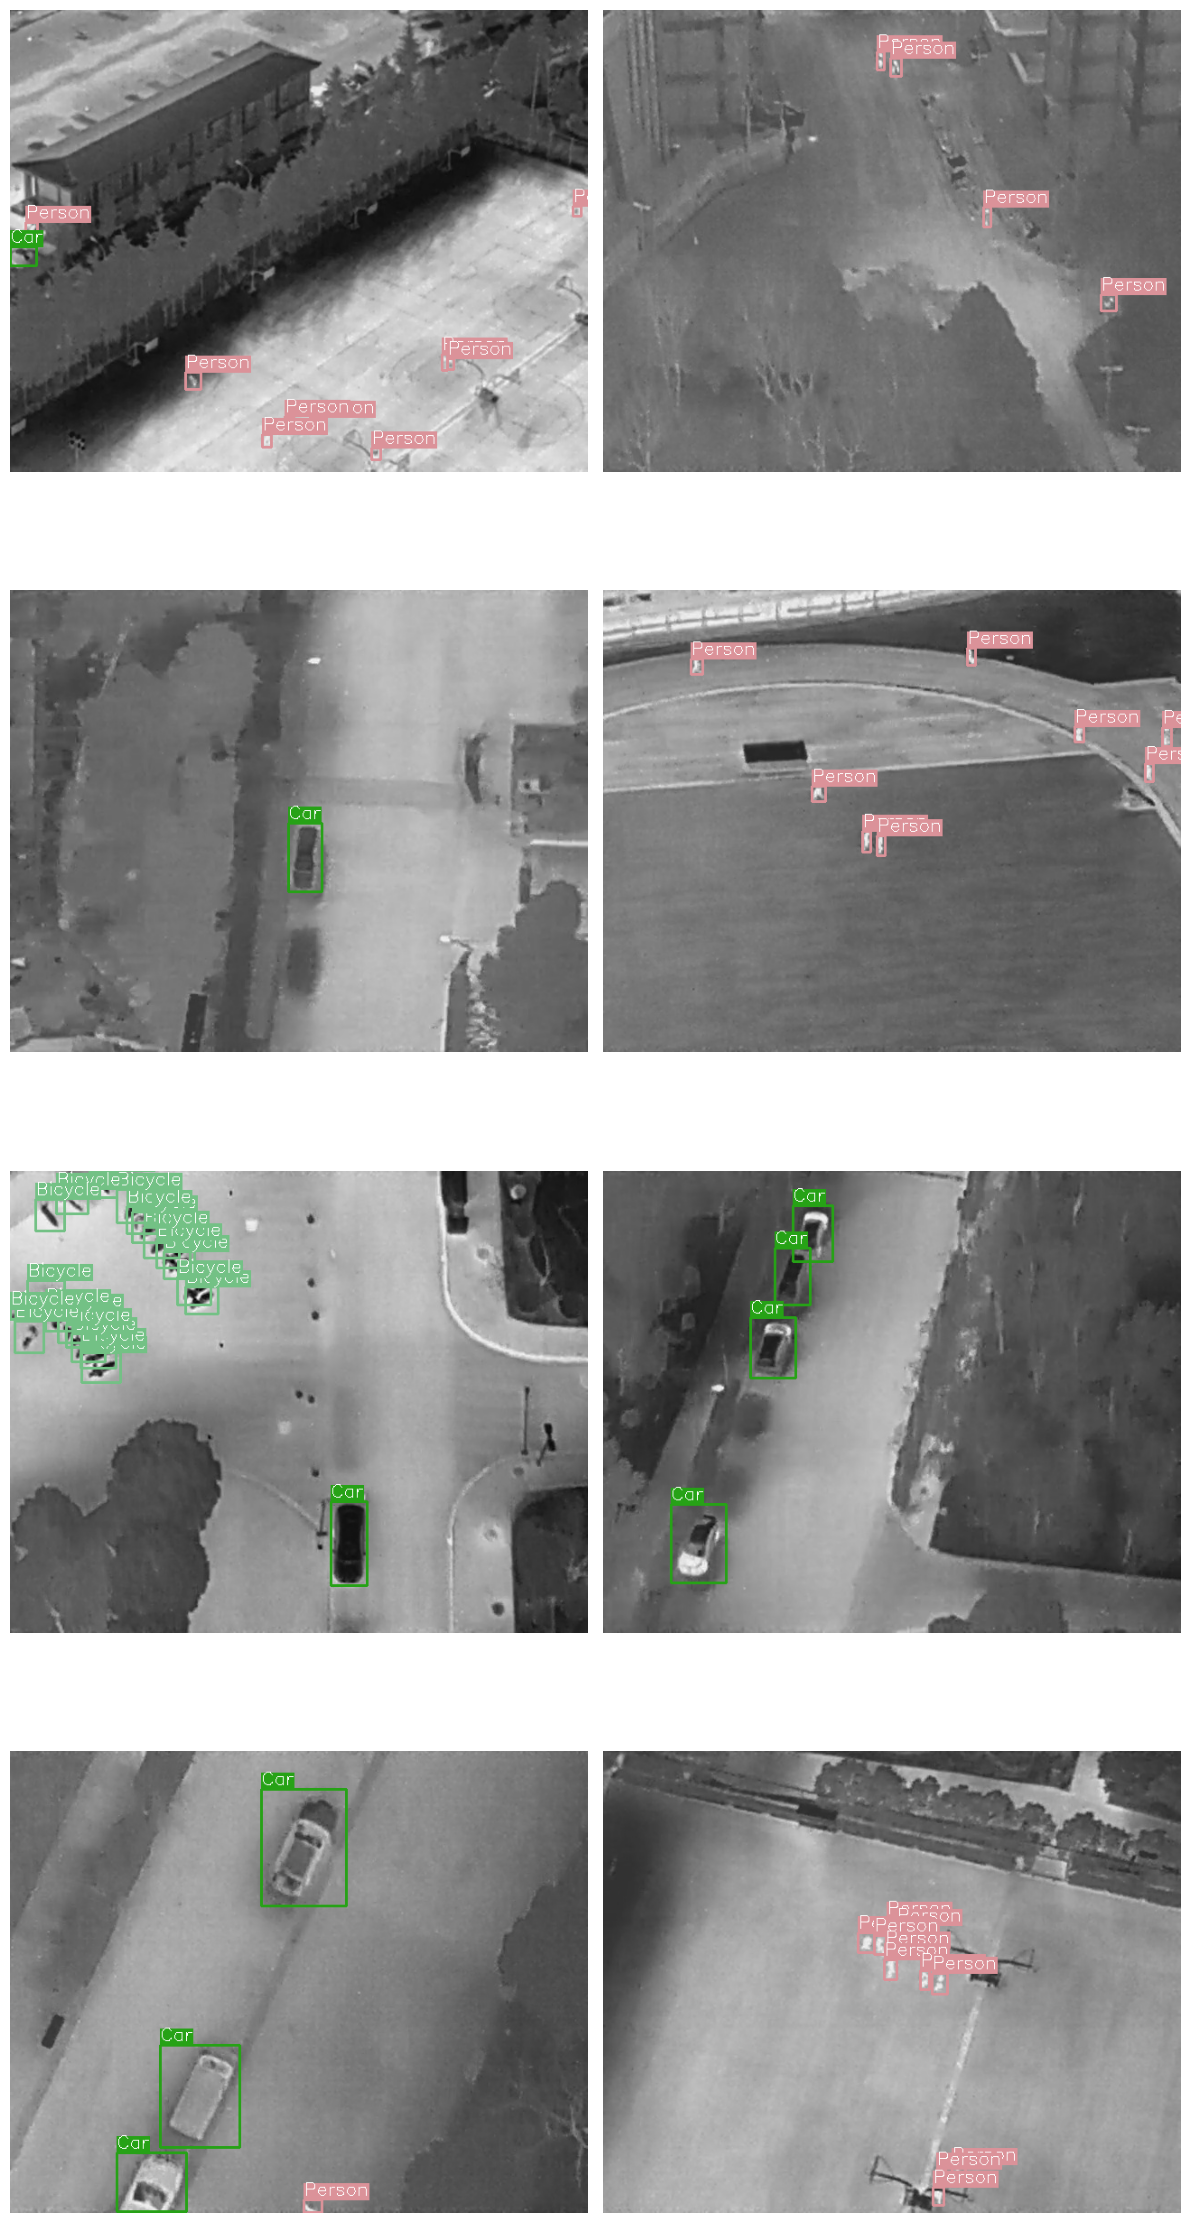

{'names': {0: 'Person', 1: 'Car', 2: 'Bicycle', 3: 'OtherVehicle', 4: 'DontCare'}, 'nc': 5, 'path': '/home/adityab/ADRL/A1/hit-uav', 'test': '/home/adityab/ADRL/A1/hit-uav/images/test', 'train': '/home/adityab/ADRL/A1/hit-uav/images/train', 'val': '/home/adityab/ADRL/A1/hit-uav/images/val'}
PRO TIP 💡 Replace 'model=yolov5m.pt' with new 'model=yolov5mu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Missing labels: 0, Empty labels: 0


In [3]:
def visualize_dataset(image_dir, label_dir, num_samples, classes=CLASS_NAMES, colors=CLASS_COLORS, label_position='above'):
    image_paths = sorted(glob.glob(image_dir + '/*'))
    label_paths = sorted(glob.glob(label_dir + '/*'))
    combined = list(zip(image_paths, label_paths))
    random.shuffle(combined)
    image_paths, label_paths = zip(*combined)

    if num_samples == -1:
        num_samples = len(image_paths)

    plt.figure(figsize=(12, 6 * (math.ceil(num_samples / 2))))
    for idx in range(num_samples):
        img_path, lbl_path = image_paths[idx], label_paths[idx]
        img = cv2.imread(img_path)
        with open(lbl_path, 'r') as lbl_file:
            bboxes, labels = [], []
            for line in lbl_file.readlines():
                label, x_center, y_center, width, height = map(float, line.split())
                bboxes.append([x_center, y_center, width, height])
                labels.append(int(label))
        annotated_img = draw_boxes(img, bboxes, labels, classes, colors, label_position)
        plt.subplot(math.ceil(num_samples / 2), 2, idx + 1)
        plt.imshow(annotated_img[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize_dataset(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR, num_samples=8)


yaml_content = {
    'path': BASE_DIR,
    'train': TRAIN_IMAGES_DIR,
    'val': VAL_IMAGES_DIR,
    'test': TEST_IMAGES_DIR,
    'names': {i: name for i, name in enumerate(CLASS_NAMES)},
    'nc': len(CLASS_NAMES)
}

with open('dataset.yaml', 'w') as yaml_file:
    yaml.dump(yaml_content, yaml_file)


with open('dataset.yaml', 'r') as file:
    data = yaml.safe_load(file)
print(data)


os.environ['WANDB_DISABLED'] = 'true'


model = YOLO("yolov5m.pt")


validation_images = os.listdir(VAL_IMAGES_DIR)
missing_labels, empty_labels = [], []

for img_file in validation_images:
    lbl_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
    lbl_path = os.path.join(VAL_LABELS_DIR, lbl_file)
    if not os.path.exists(lbl_path):
        missing_labels.append(img_file)
    else:
        with open(lbl_path, 'r') as file:
            if not file.readlines():
                empty_labels.append(lbl_file)

print(f'Missing labels: {len(missing_labels)}, Empty labels: {len(empty_labels)}')

if missing_labels:
    print("Missing labels:", missing_labels)
if empty_labels:
    print("Empty labels:", empty_labels)

In [4]:

results = model.train(
    data='dataset.yaml',
    imgsz=512,
    epochs=50,
    batch=16,
    name='yolov5m_custom_training'
)

Ultralytics 8.3.38 🚀 Python-3.8.10 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)
engine/trainer: task=detect, mode=train, model=yolov5m.pt, data=dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov5m_custom_training2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  6   2512896  ultralytics.nn.modules.block.C3              [384, 384, 6]                 
  7                  -1  1   2655744  ultralytics

train: Scanning /home/adityab/ADRL/A1/hit-uav/labels/train.cache... 2008 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2008/2008 [00:00<?, ?it/s]
val: Scanning /home/adityab/ADRL/A1/hit-uav/labels/val.cache... 287 images, 0 backgrounds, 0 corrupt: 100%|██████████| 287/287 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov5m_custom_training2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 91 weight(decay=0.0), 98 weight(decay=0.0005), 97 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/yolov5m_custom_training2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.58G      1.645      1.597      1.083        154        512: 100%|██████████| 126/126 [00:17<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.30it/s]

                   all        287       2460      0.813      0.369      0.403      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.55G      1.603      1.186      1.057        164        512: 100%|██████████| 126/126 [00:15<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.61it/s]

                   all        287       2460      0.804      0.322      0.361      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.42G      1.563      1.113      1.032         98        512: 100%|██████████| 126/126 [00:15<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.49it/s]

                   all        287       2460      0.613      0.372      0.408      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.55G      1.535      1.061       1.04         40        512: 100%|██████████| 126/126 [00:15<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.79it/s]

                   all        287       2460      0.657      0.401      0.459      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.51G      1.525      1.028      1.019        140        512: 100%|██████████| 126/126 [00:15<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.72it/s]

                   all        287       2460      0.623      0.472      0.526      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.51G      1.448     0.9399      1.012        100        512: 100%|██████████| 126/126 [00:15<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.78it/s]

                   all        287       2460      0.651      0.479       0.54      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.46G      1.456     0.9538      1.011         70        512: 100%|██████████| 126/126 [00:15<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.72it/s]

                   all        287       2460      0.716      0.528       0.58      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       4.5G      1.424     0.8869     0.9988        114        512: 100%|██████████| 126/126 [00:15<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.41it/s]

                   all        287       2460      0.698      0.559      0.606      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.5G      1.391     0.8616      0.987        140        512: 100%|██████████| 126/126 [00:15<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.69it/s]

                   all        287       2460      0.582      0.562      0.556      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.53G      1.377     0.8435     0.9852         86        512: 100%|██████████| 126/126 [00:15<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.83it/s]

                   all        287       2460      0.566      0.616      0.582       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.54G      1.352     0.8191     0.9763         92        512: 100%|██████████| 126/126 [00:15<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.81it/s]

                   all        287       2460      0.759      0.536      0.625      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.55G      1.329     0.7941     0.9681         71        512: 100%|██████████| 126/126 [00:15<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.85it/s]

                   all        287       2460      0.793      0.644      0.712      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.54G      1.346     0.7823     0.9655        125        512: 100%|██████████| 126/126 [00:15<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.87it/s]

                   all        287       2460      0.786      0.613      0.658      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       4.5G      1.299     0.7753     0.9621         94        512: 100%|██████████| 126/126 [00:15<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.81it/s]

                   all        287       2460      0.619      0.598      0.603      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.58G      1.301     0.7572     0.9585         63        512: 100%|██████████| 126/126 [00:15<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.82it/s]

                   all        287       2460      0.749      0.639      0.703      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.49G      1.286     0.7453     0.9579         74        512: 100%|██████████| 126/126 [00:15<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.85it/s]

                   all        287       2460      0.814       0.61      0.707       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       4.5G      1.278     0.7336     0.9546        142        512: 100%|██████████| 126/126 [00:15<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.70it/s]

                   all        287       2460      0.779      0.598       0.69      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.52G      1.281      0.726     0.9523         99        512: 100%|██████████| 126/126 [00:15<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.80it/s]

                   all        287       2460      0.662      0.629      0.653      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.56G      1.265     0.7227     0.9463         95        512: 100%|██████████| 126/126 [00:15<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.91it/s]

                   all        287       2460      0.729      0.669      0.687      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.52G      1.242     0.6975     0.9439        141        512: 100%|██████████| 126/126 [00:15<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.87it/s]

                   all        287       2460       0.84       0.68      0.695      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.51G      1.231     0.6831     0.9388         80        512: 100%|██████████| 126/126 [00:15<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.00it/s]

                   all        287       2460      0.716      0.654      0.685      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.55G      1.241     0.6786     0.9373        187        512: 100%|██████████| 126/126 [00:15<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.87it/s]

                   all        287       2460      0.773       0.67      0.693      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       4.5G      1.206     0.6576     0.9354        107        512: 100%|██████████| 126/126 [00:15<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.80it/s]

                   all        287       2460      0.786      0.701       0.74      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.54G      1.234     0.6726     0.9312        110        512: 100%|██████████| 126/126 [00:15<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.53it/s]

                   all        287       2460      0.808      0.655      0.737      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.51G      1.194     0.6563     0.9273        124        512: 100%|██████████| 126/126 [00:15<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.85it/s]

                   all        287       2460      0.775      0.643      0.701      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.52G      1.202     0.6486     0.9303        103        512: 100%|██████████| 126/126 [00:15<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.88it/s]

                   all        287       2460      0.831      0.653      0.746      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.53G      1.182     0.6359     0.9254         98        512: 100%|██████████| 126/126 [00:15<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.99it/s]

                   all        287       2460      0.832      0.679      0.755      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.55G      1.174     0.6344     0.9251        101        512: 100%|██████████| 126/126 [00:15<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.93it/s]

                   all        287       2460       0.66      0.704      0.692      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.54G      1.178     0.6291     0.9179        164        512: 100%|██████████| 126/126 [00:15<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.66it/s]

                   all        287       2460       0.79      0.663      0.718      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.54G      1.171     0.6161     0.9167        138        512: 100%|██████████| 126/126 [00:15<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.73it/s]

                   all        287       2460      0.838      0.674      0.747      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.55G      1.152      0.607     0.9175        160        512: 100%|██████████| 126/126 [00:15<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.86it/s]

                   all        287       2460      0.801       0.67      0.722      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.51G       1.15     0.6019     0.9158         76        512: 100%|██████████| 126/126 [00:15<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.42it/s]

                   all        287       2460       0.76      0.708      0.749      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.54G      1.146     0.6065     0.9096        142        512: 100%|██████████| 126/126 [00:15<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.61it/s]

                   all        287       2460      0.828      0.631      0.723       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.51G      1.106     0.5801     0.9103        124        512: 100%|██████████| 126/126 [00:15<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.52it/s]

                   all        287       2460      0.895      0.724      0.782      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.55G      1.122      0.581     0.9065        153        512: 100%|██████████| 126/126 [00:15<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.96it/s]

                   all        287       2460      0.833      0.658      0.743      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       4.5G      1.125     0.5791     0.9034         81        512: 100%|██████████| 126/126 [00:15<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.82it/s]

                   all        287       2460      0.855      0.712       0.76      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.55G        1.1     0.5665     0.8997        101        512: 100%|██████████| 126/126 [00:15<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.89it/s]

                   all        287       2460      0.751      0.648      0.729      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.54G       1.09     0.5637     0.9027         84        512: 100%|██████████| 126/126 [00:15<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.85it/s]

                   all        287       2460      0.812      0.726      0.775      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.52G      1.111     0.5724      0.899         66        512: 100%|██████████| 126/126 [00:15<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.76it/s]

                   all        287       2460      0.776      0.681       0.75      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.57G      1.093     0.5609     0.9014        118        512: 100%|██████████| 126/126 [00:15<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.91it/s]

                   all        287       2460      0.864      0.716      0.784      0.503


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.55G      1.091     0.5481     0.9058         74        512: 100%|██████████| 126/126 [00:15<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.84it/s]

                   all        287       2460      0.862      0.728       0.79      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.46G      1.093     0.5357     0.9046         42        512: 100%|██████████| 126/126 [00:15<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.73it/s]

                   all        287       2460      0.861      0.731      0.782      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       4.5G      1.081     0.5313     0.8982         35        512: 100%|██████████| 126/126 [00:15<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.86it/s]

                   all        287       2460      0.784      0.643      0.705      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.48G      1.067     0.5267     0.8951        108        512: 100%|██████████| 126/126 [00:15<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.87it/s]

                   all        287       2460      0.823      0.716      0.771      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.46G      1.053     0.5126     0.8915         92        512: 100%|██████████| 126/126 [00:15<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.90it/s]

                   all        287       2460      0.855      0.731      0.783      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.54G      1.053     0.5104     0.8923         77        512: 100%|██████████| 126/126 [00:15<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.86it/s]

                   all        287       2460      0.849      0.714      0.782      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.55G      1.042     0.5077     0.8845         59        512: 100%|██████████| 126/126 [00:15<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]

                   all        287       2460      0.866      0.699      0.792      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.54G      1.041     0.5066     0.8884         57        512: 100%|██████████| 126/126 [00:15<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.83it/s]

                   all        287       2460      0.842      0.671      0.776      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.47G      1.014     0.4936     0.8844         22        512: 100%|██████████| 126/126 [00:15<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.72it/s]

                   all        287       2460      0.832      0.733      0.798      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.53G      1.015     0.4905     0.8826         57        512: 100%|██████████| 126/126 [00:15<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.67it/s]

                   all        287       2460      0.872      0.719      0.797      0.521



50 epochs completed in 0.247 hours.
Optimizer stripped from runs/detect/yolov5m_custom_training2/weights/last.pt, 50.5MB
Optimizer stripped from runs/detect/yolov5m_custom_training2/weights/best.pt, 50.5MB

Validating runs/detect/yolov5m_custom_training2/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.8.10 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)
YOLOv5m summary (fused): 248 layers, 25,048,111 parameters, 0 gradients, 64.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


                   all        287       2460      0.833      0.733      0.798      0.523
                Person        171       1168      0.912      0.822       0.91      0.507
                   Car        136        719      0.945      0.961      0.986      0.775
               Bicycle         53        554      0.899      0.816      0.912      0.559
          OtherVehicle          9         12      0.792      0.636      0.752      0.635
              DontCare          5          7      0.615      0.429      0.432       0.14
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/yolov5m_custom_training2



Training Metrics (CSV):
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
45     46  812.345         1.05296         0.51039         0.89230   
46     47  829.978         1.04206         0.50767         0.88453   
47     48  847.330         1.04114         0.50660         0.88836   
48     49  864.471         1.01399         0.49363         0.88437   
49     50  882.011         1.01546         0.49050         0.88255   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
45               0.84893            0.71384           0.78237   
46               0.86648            0.69940           0.79162   
47               0.84182            0.67088           0.77607   
48               0.83203            0.73309           0.79809   
49               0.87176            0.71888           0.79672   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
45              0.48760       1.15502       0.57211       0.91443  0.000121   
46   

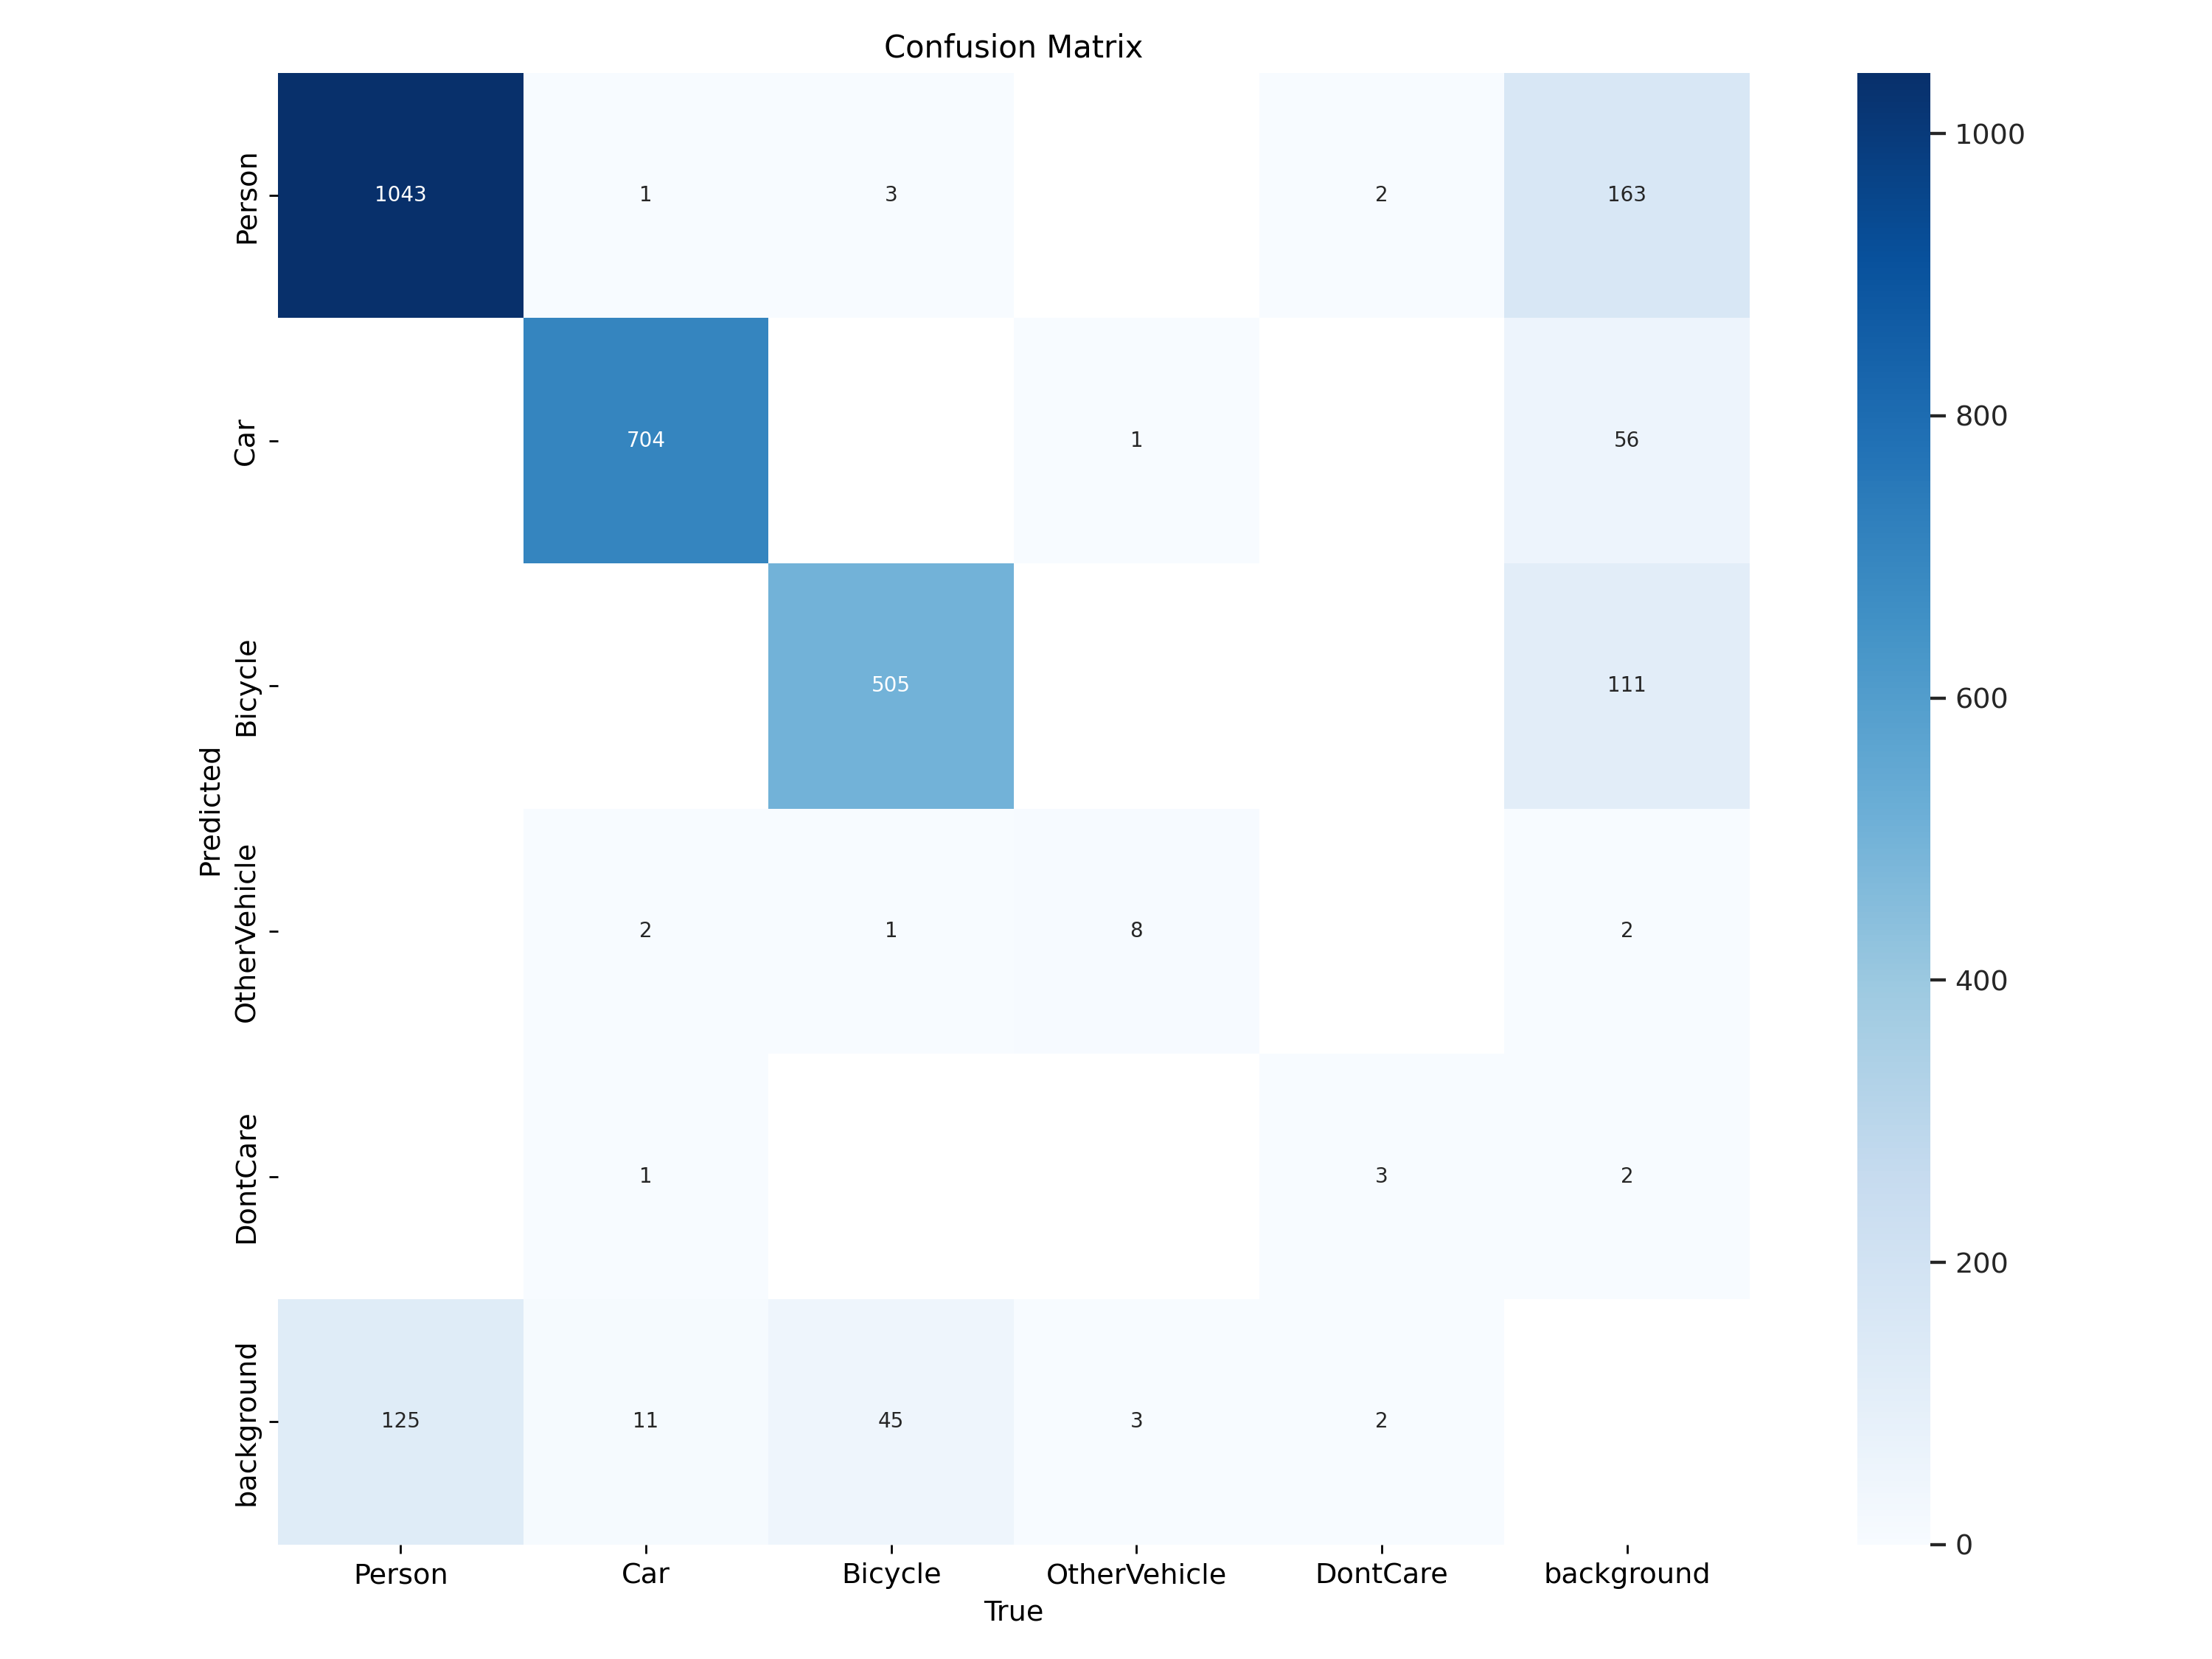


Displaying: confusion_matrix_normalized.png


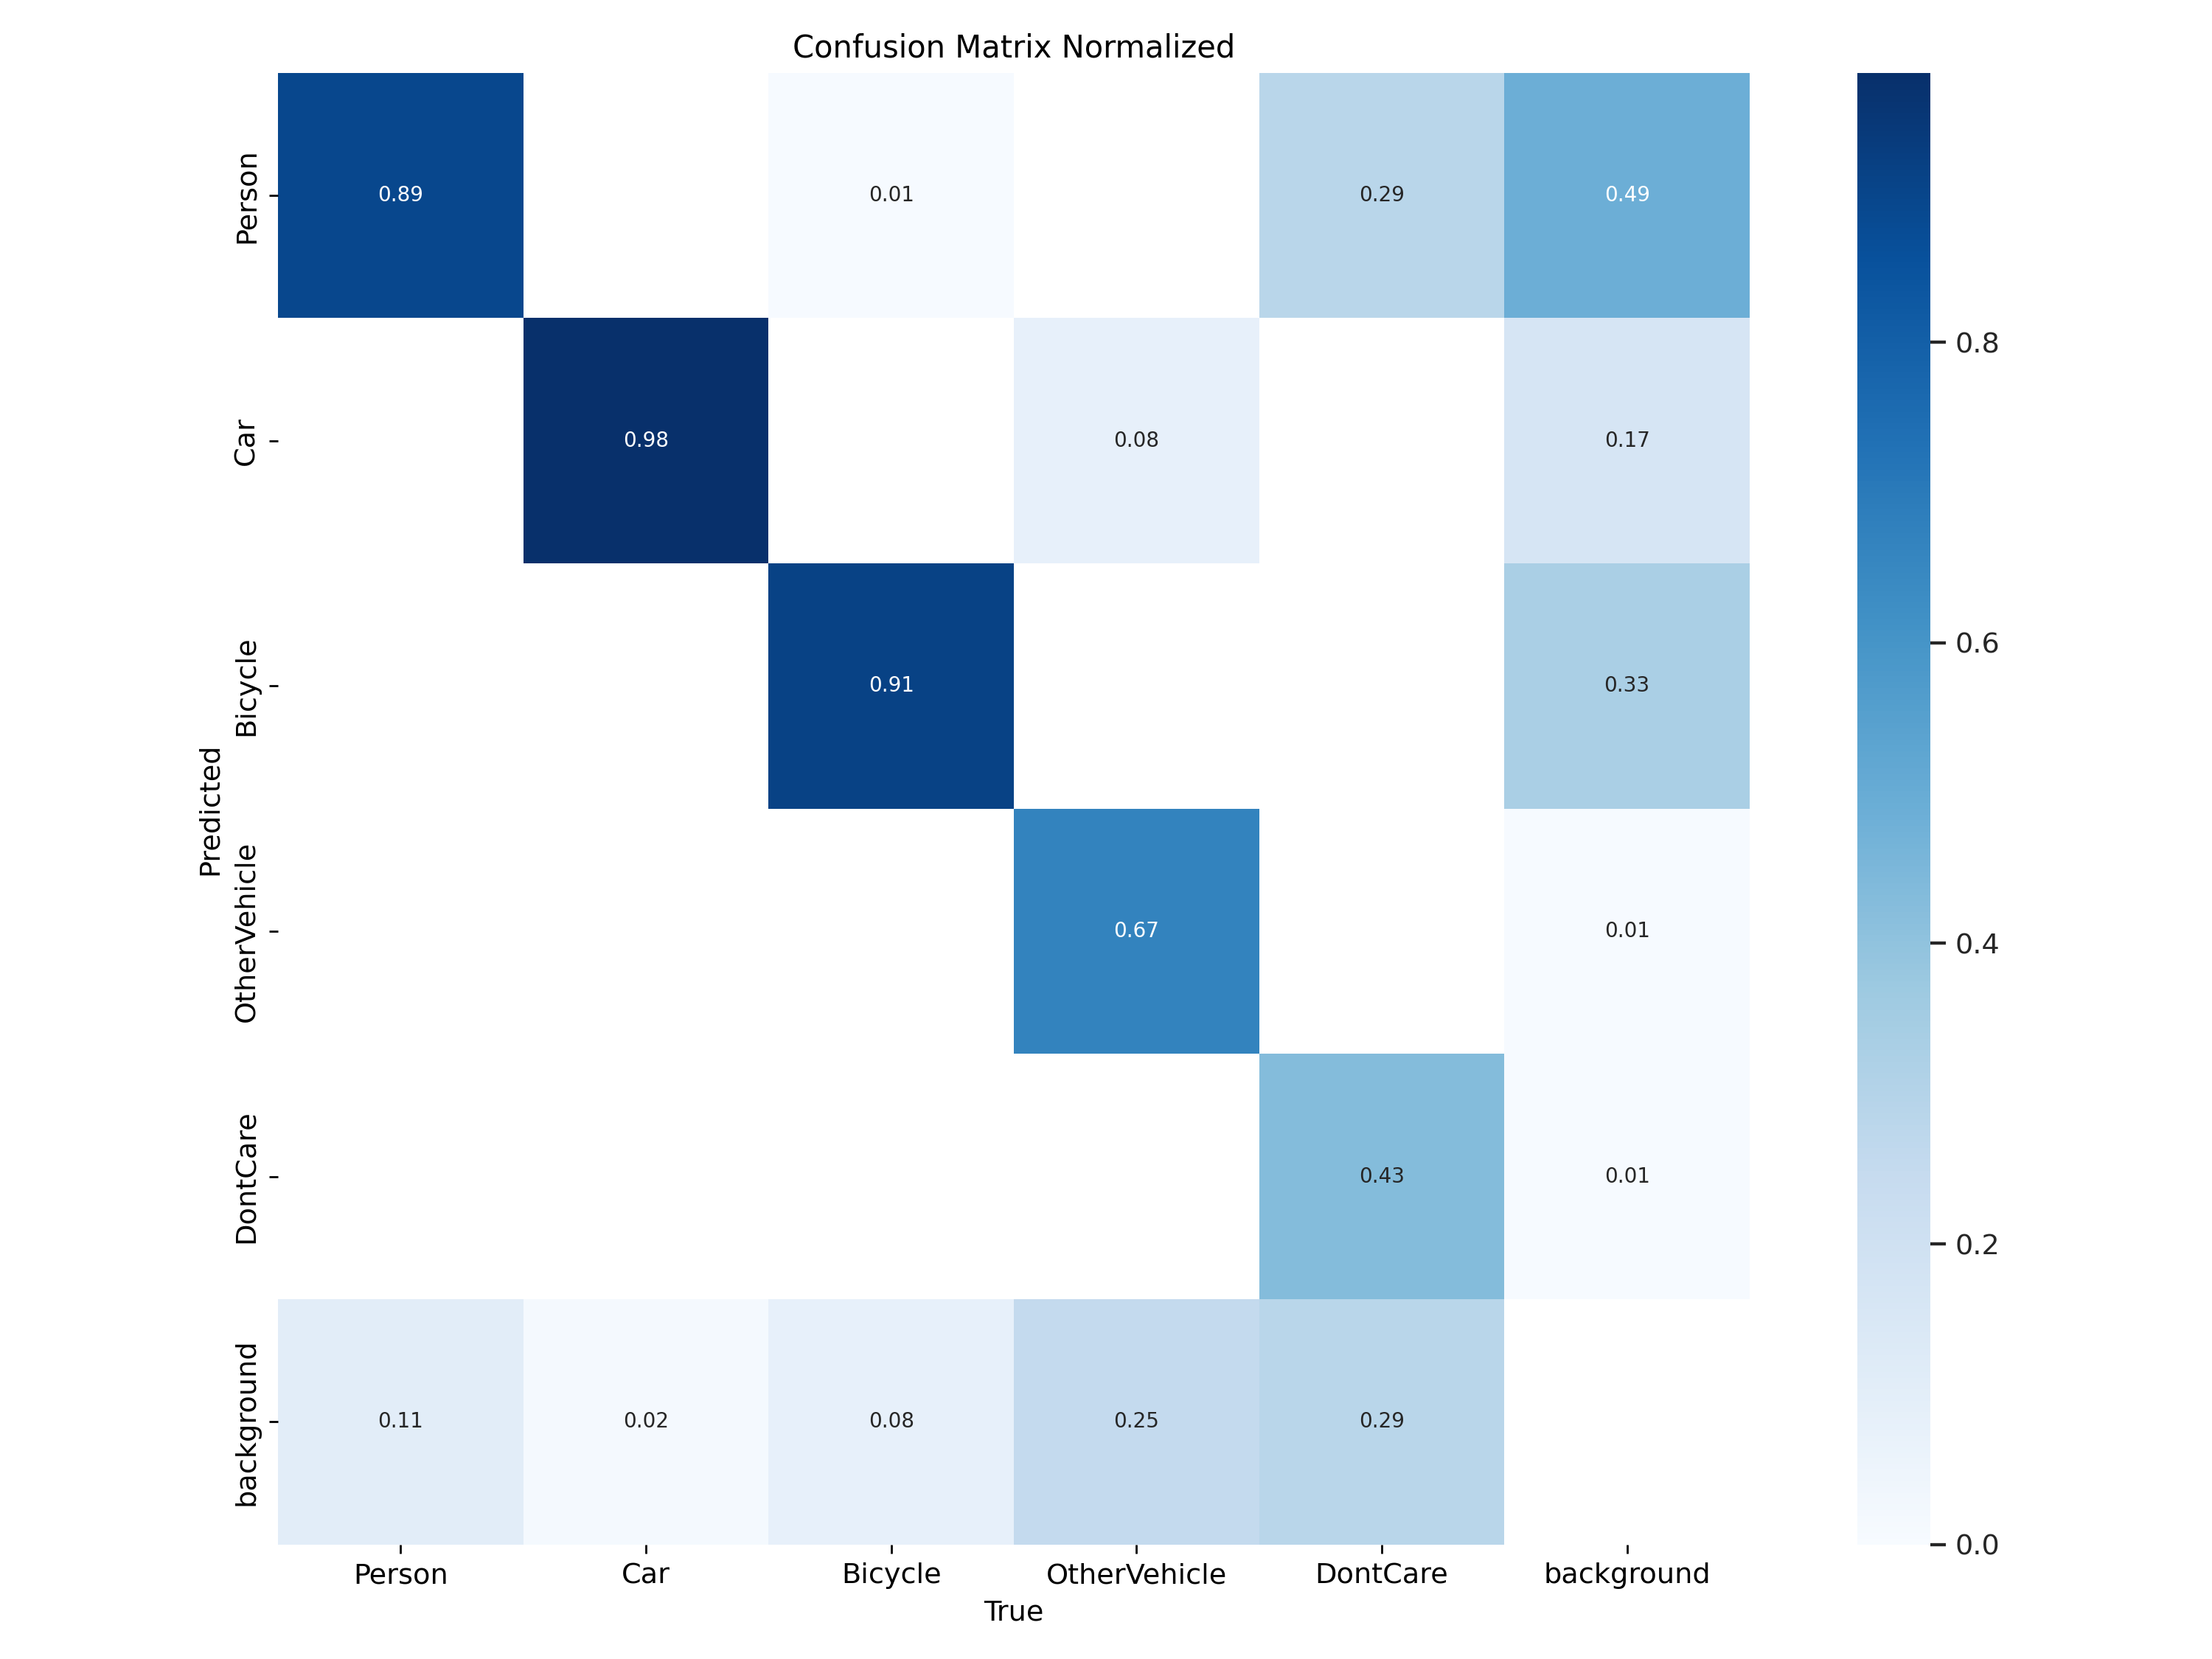


Displaying: F1_curve.png


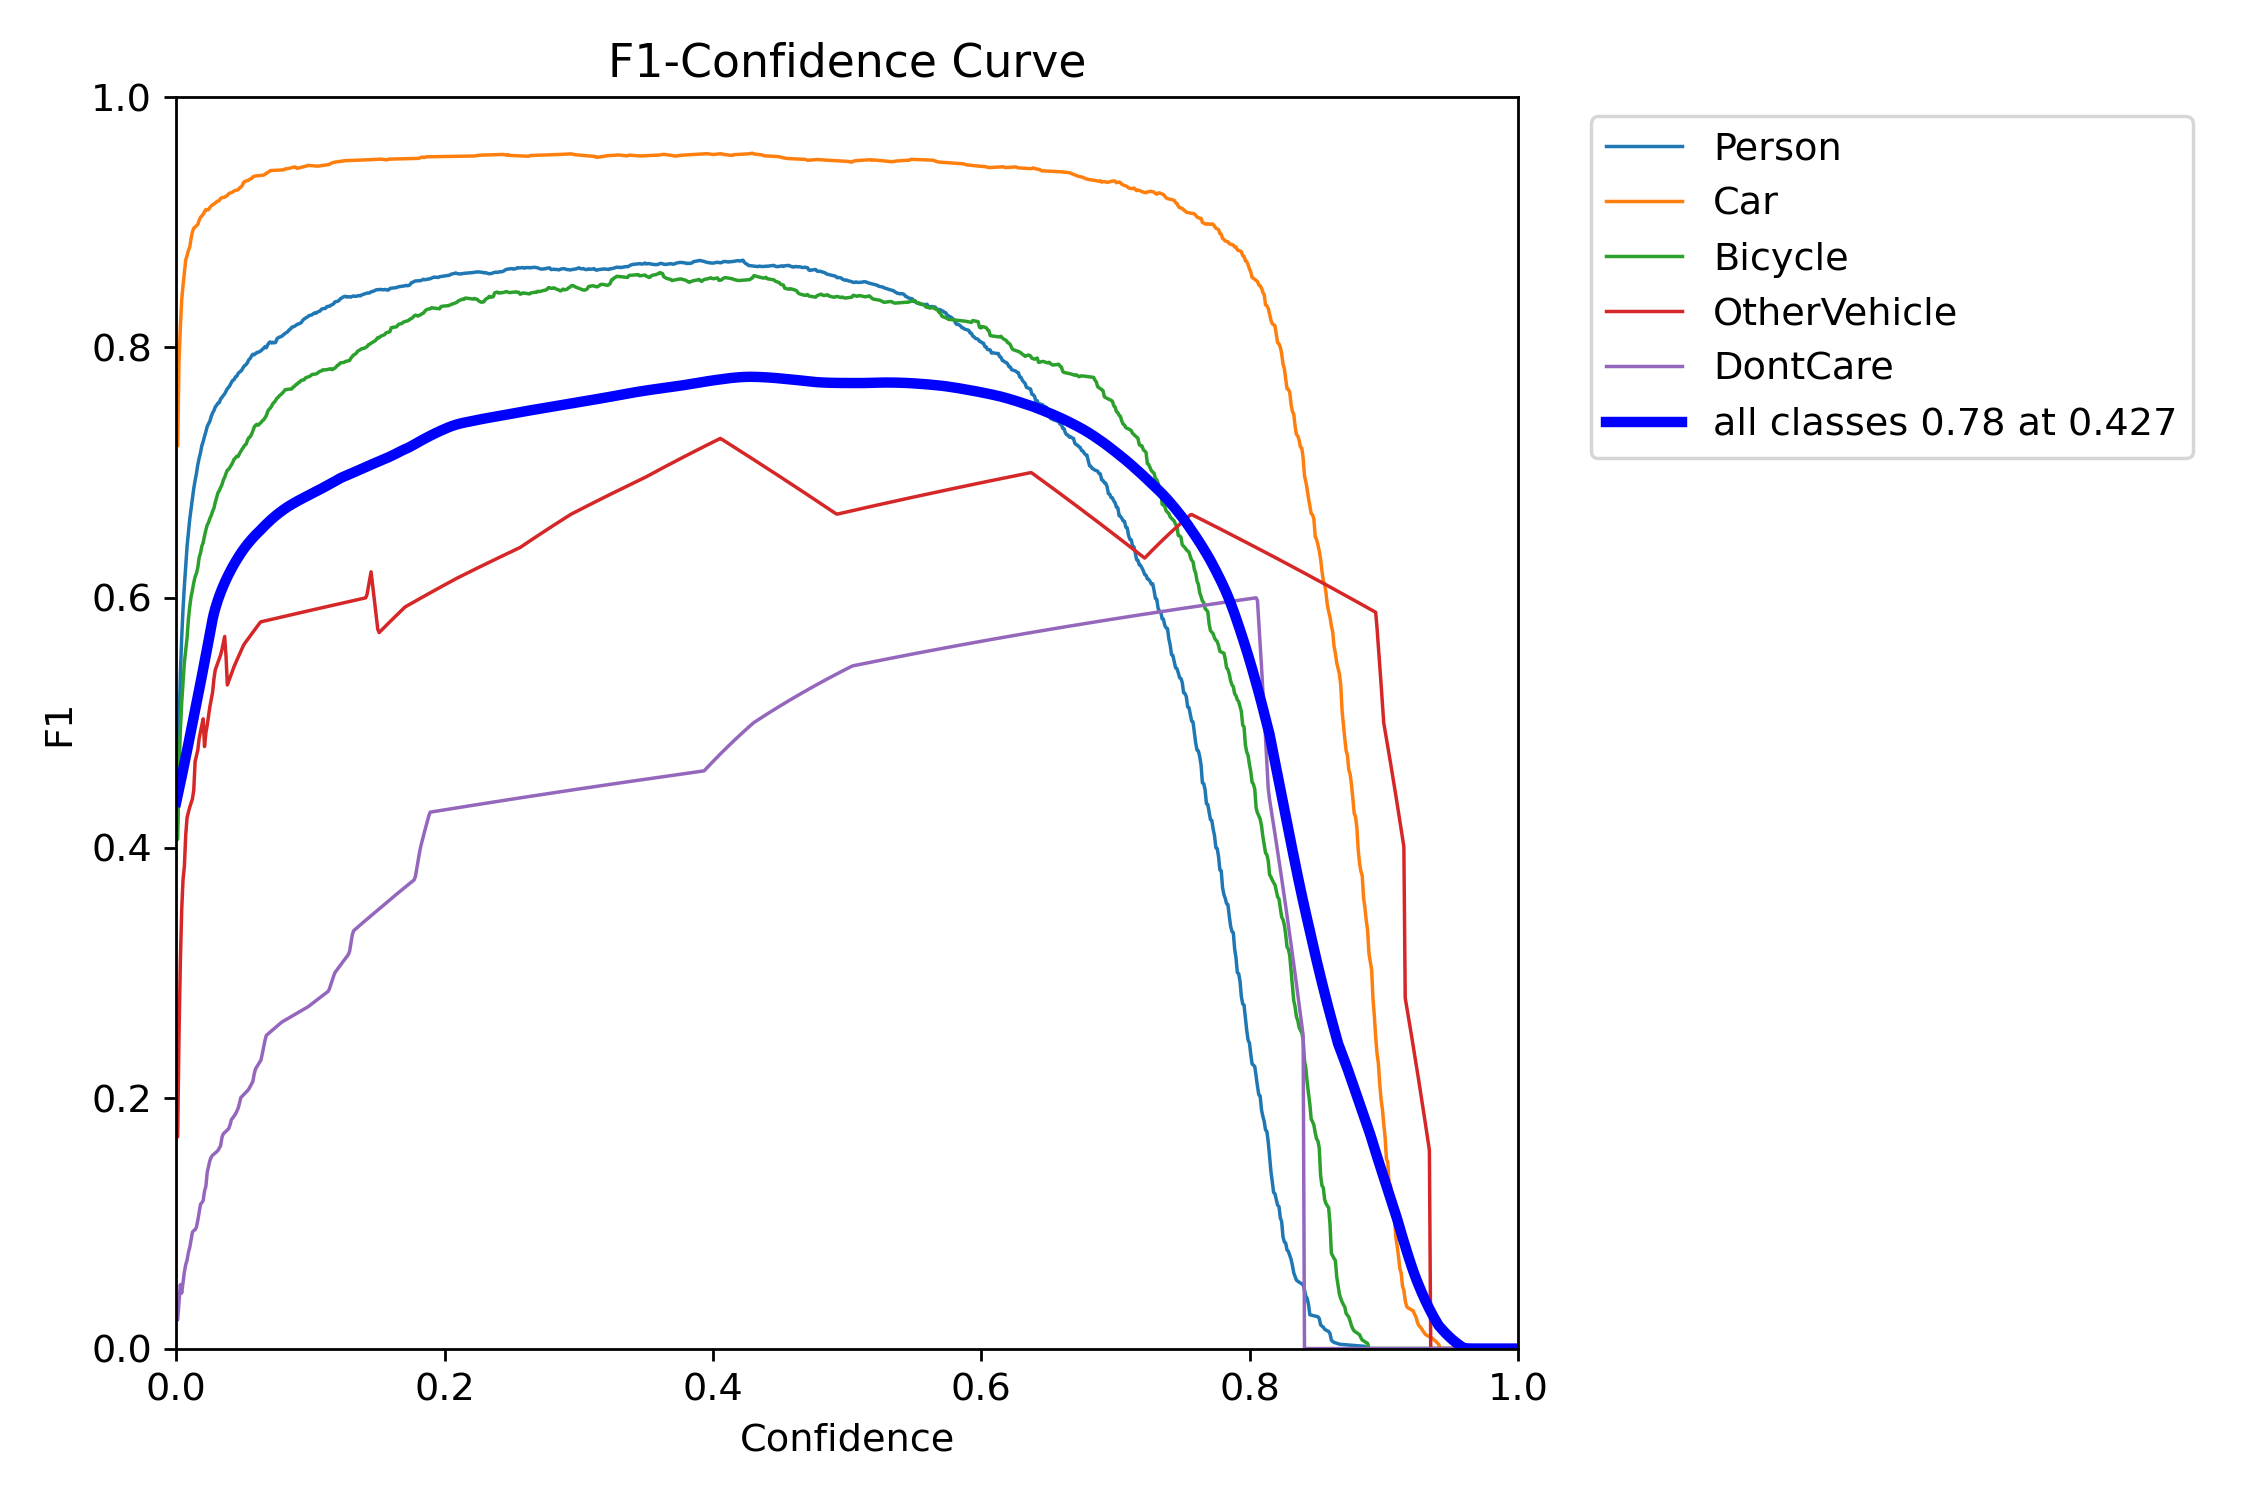


Displaying: PR_curve.png


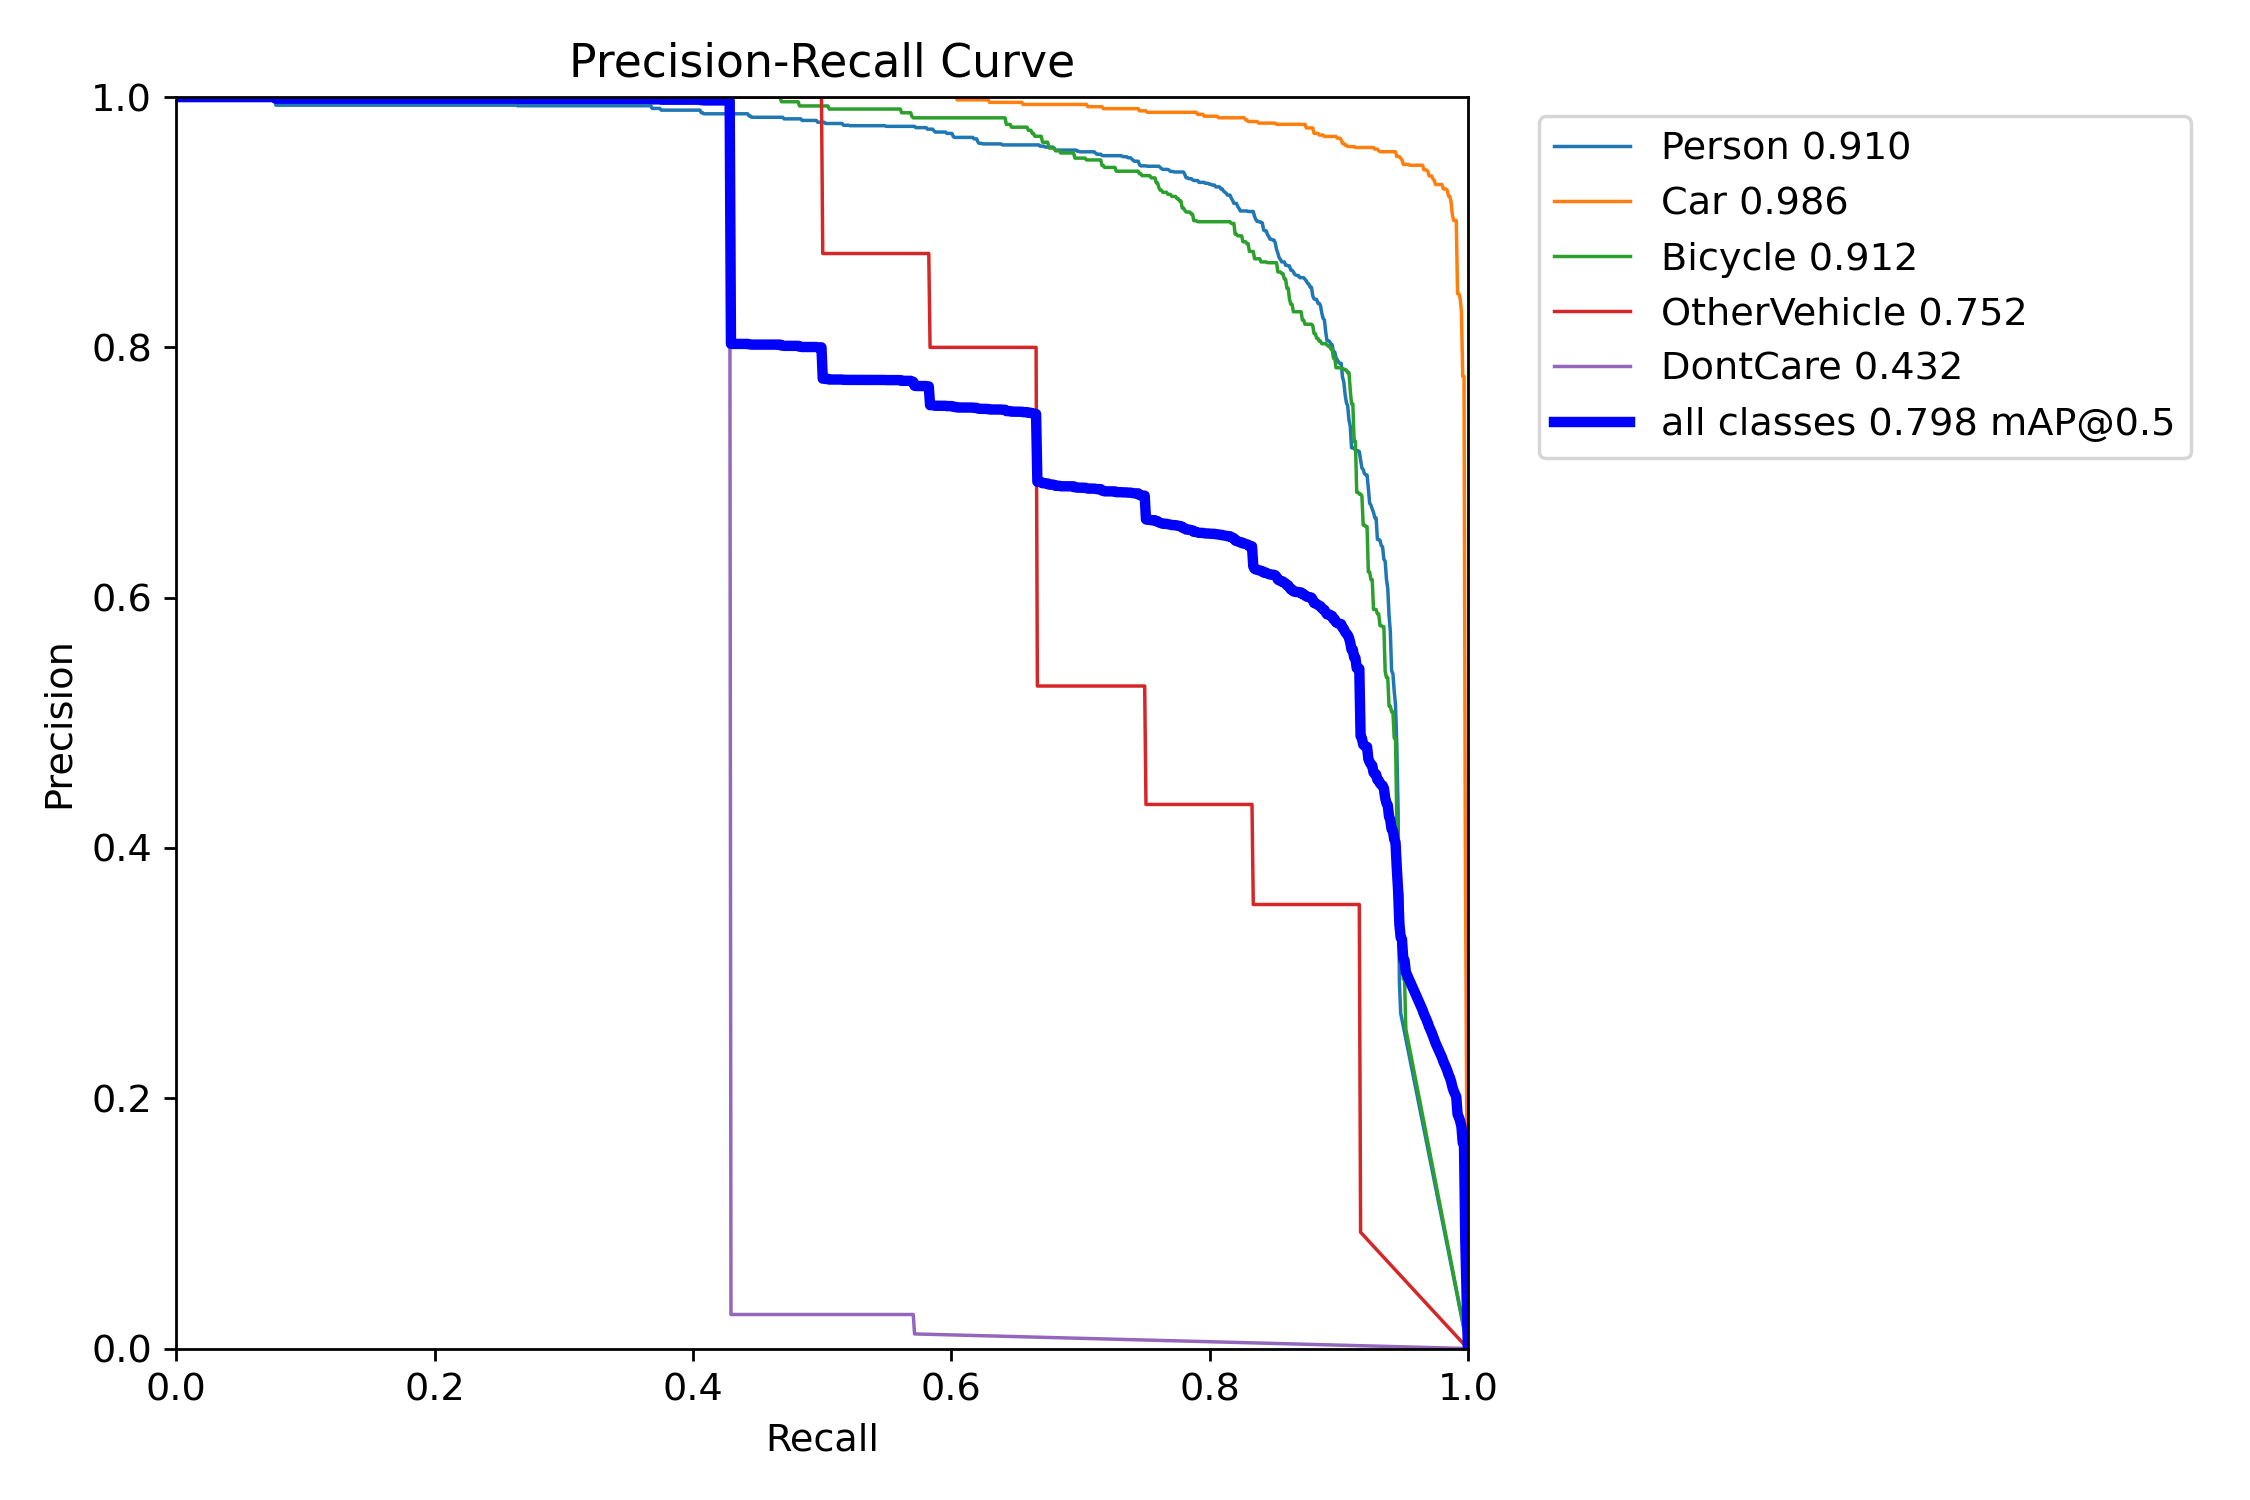


Displaying: P_curve.png


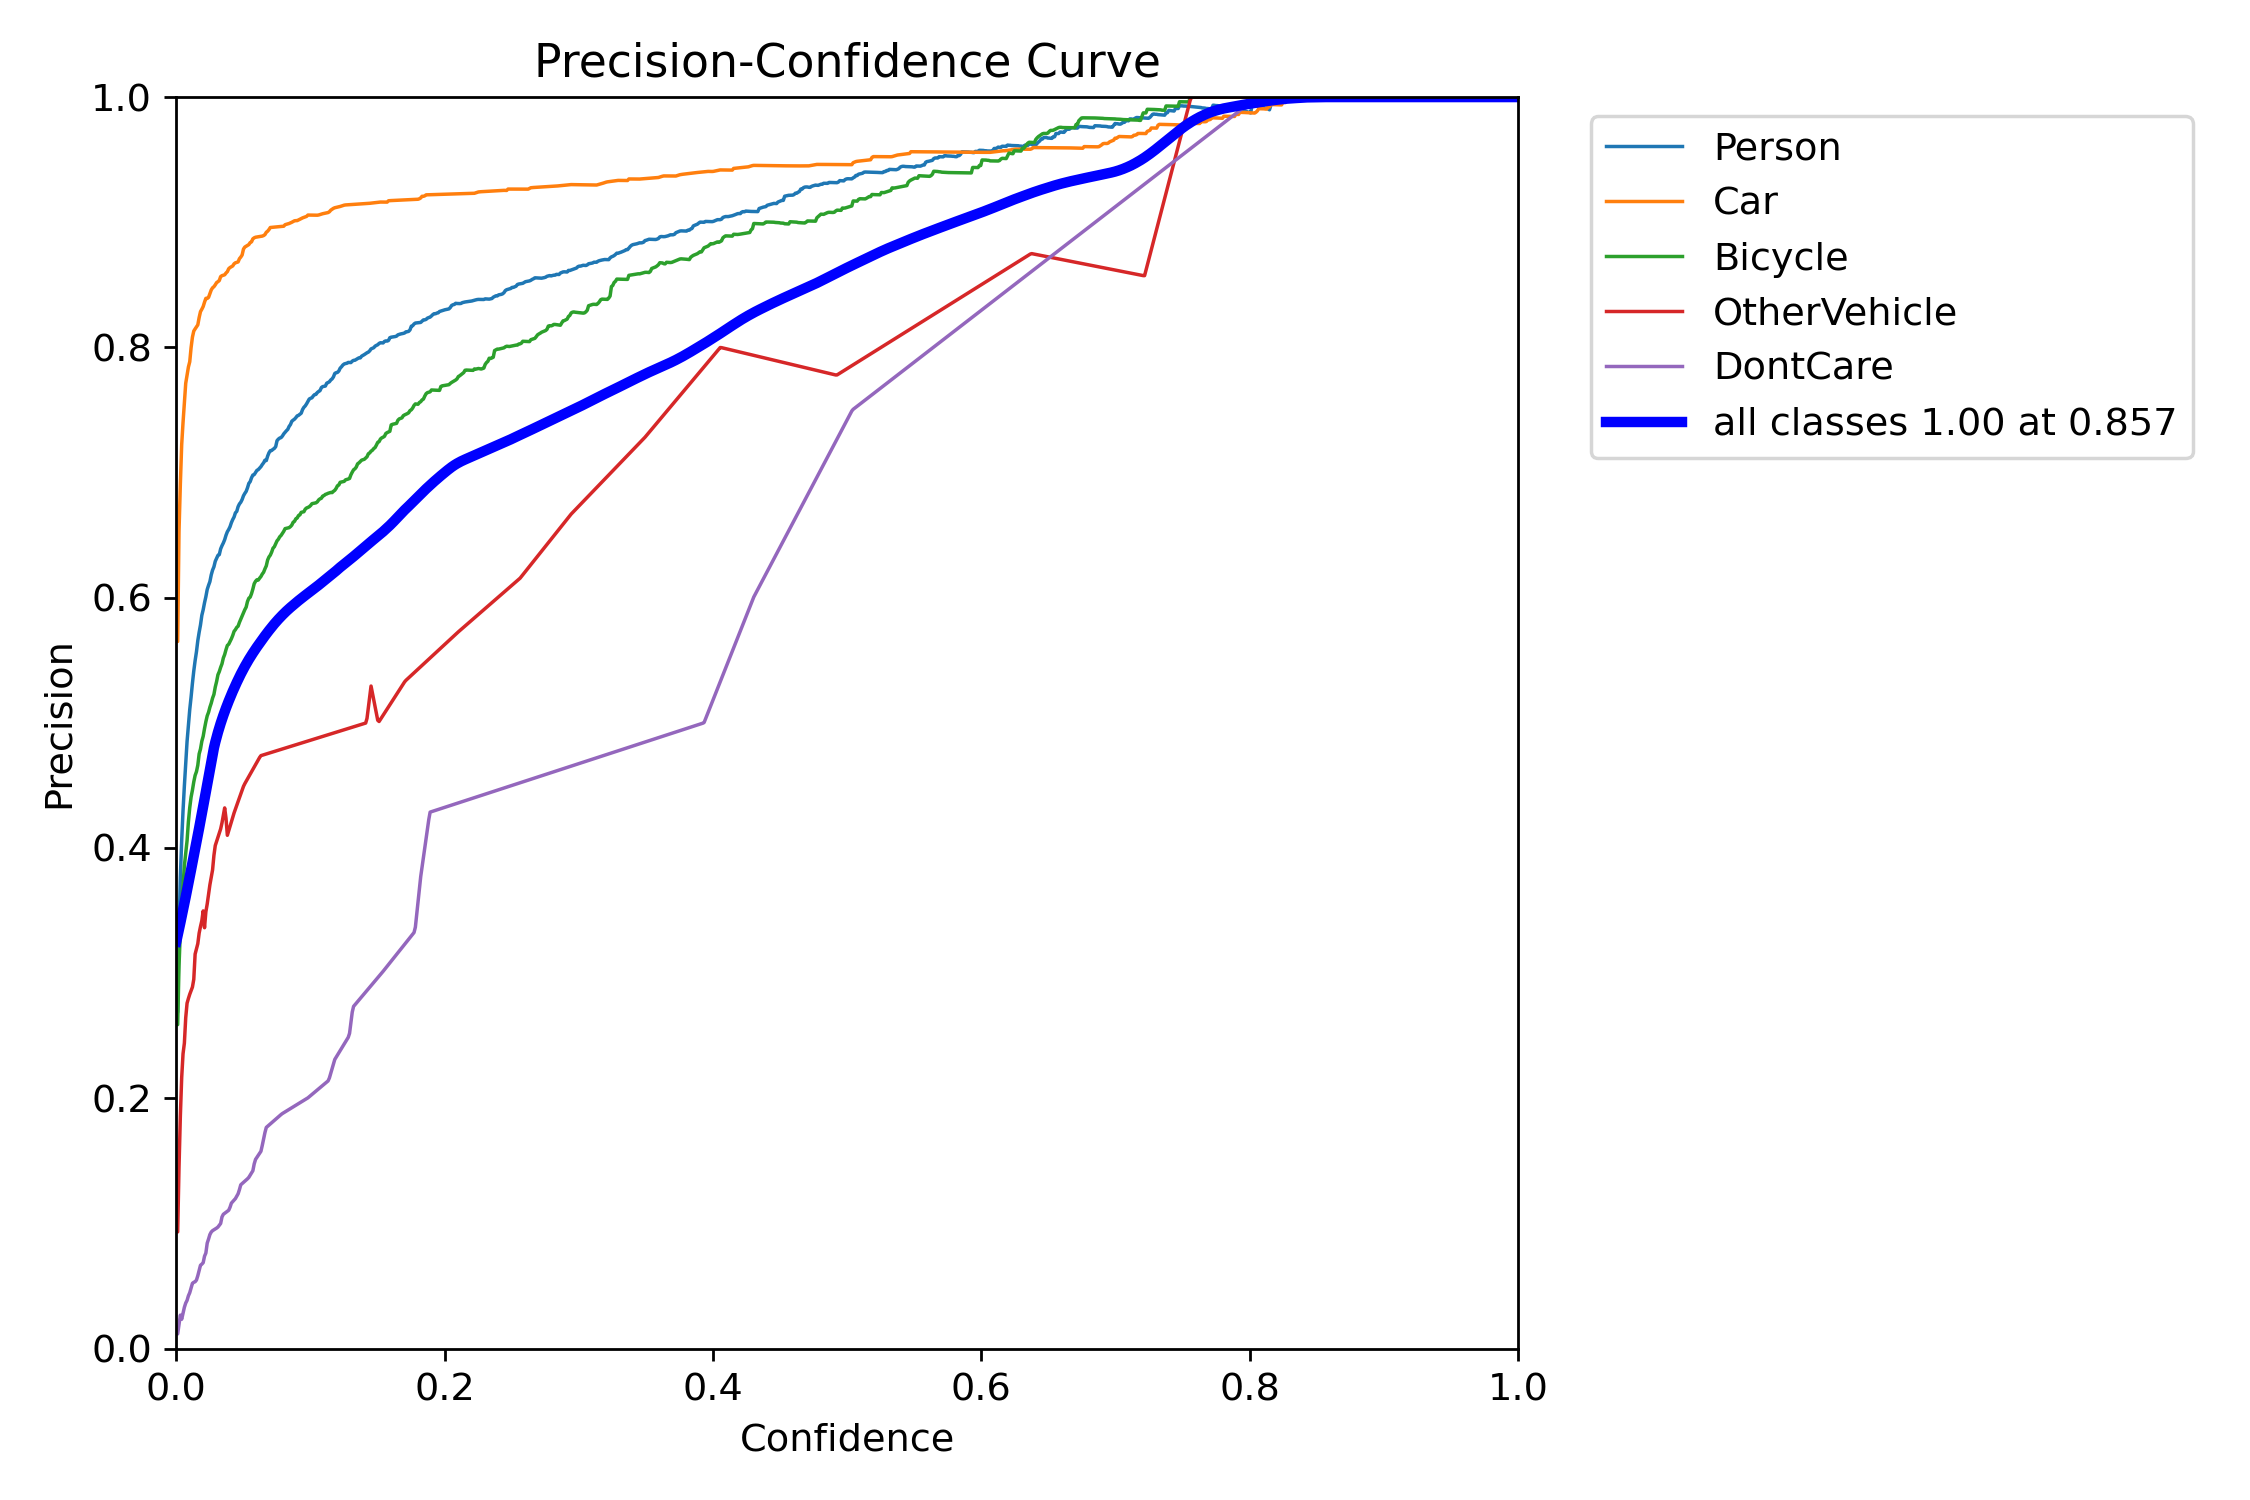


Displaying: R_curve.png


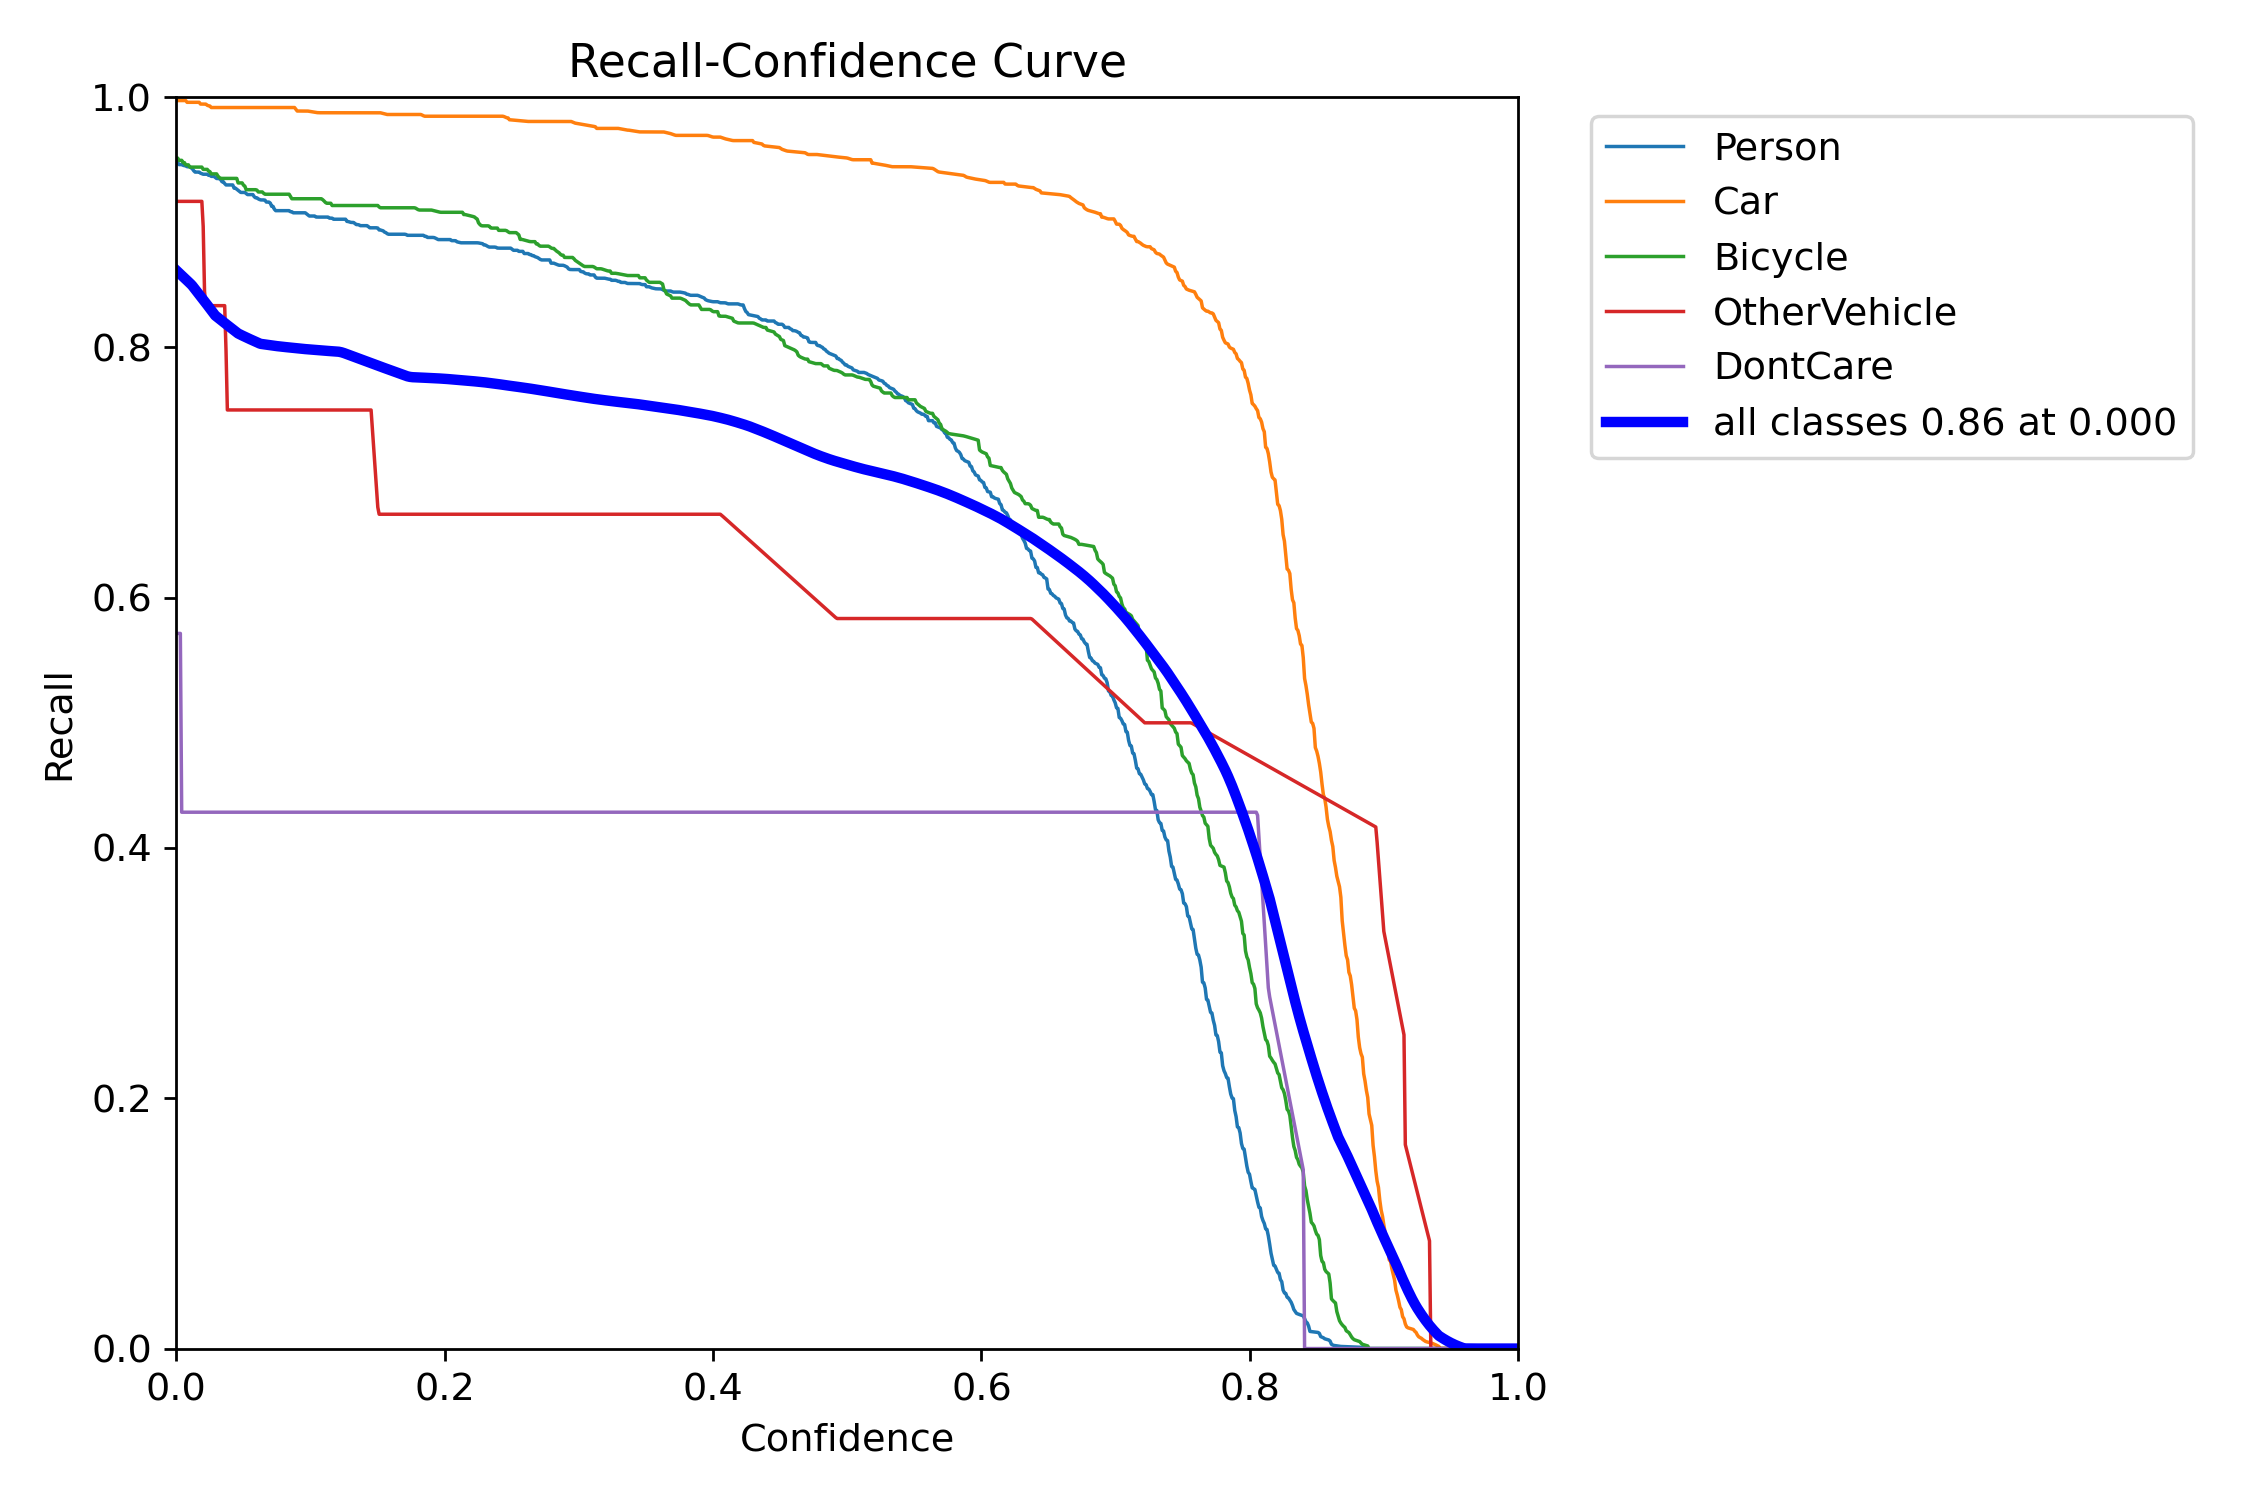


Displaying: labels.jpg


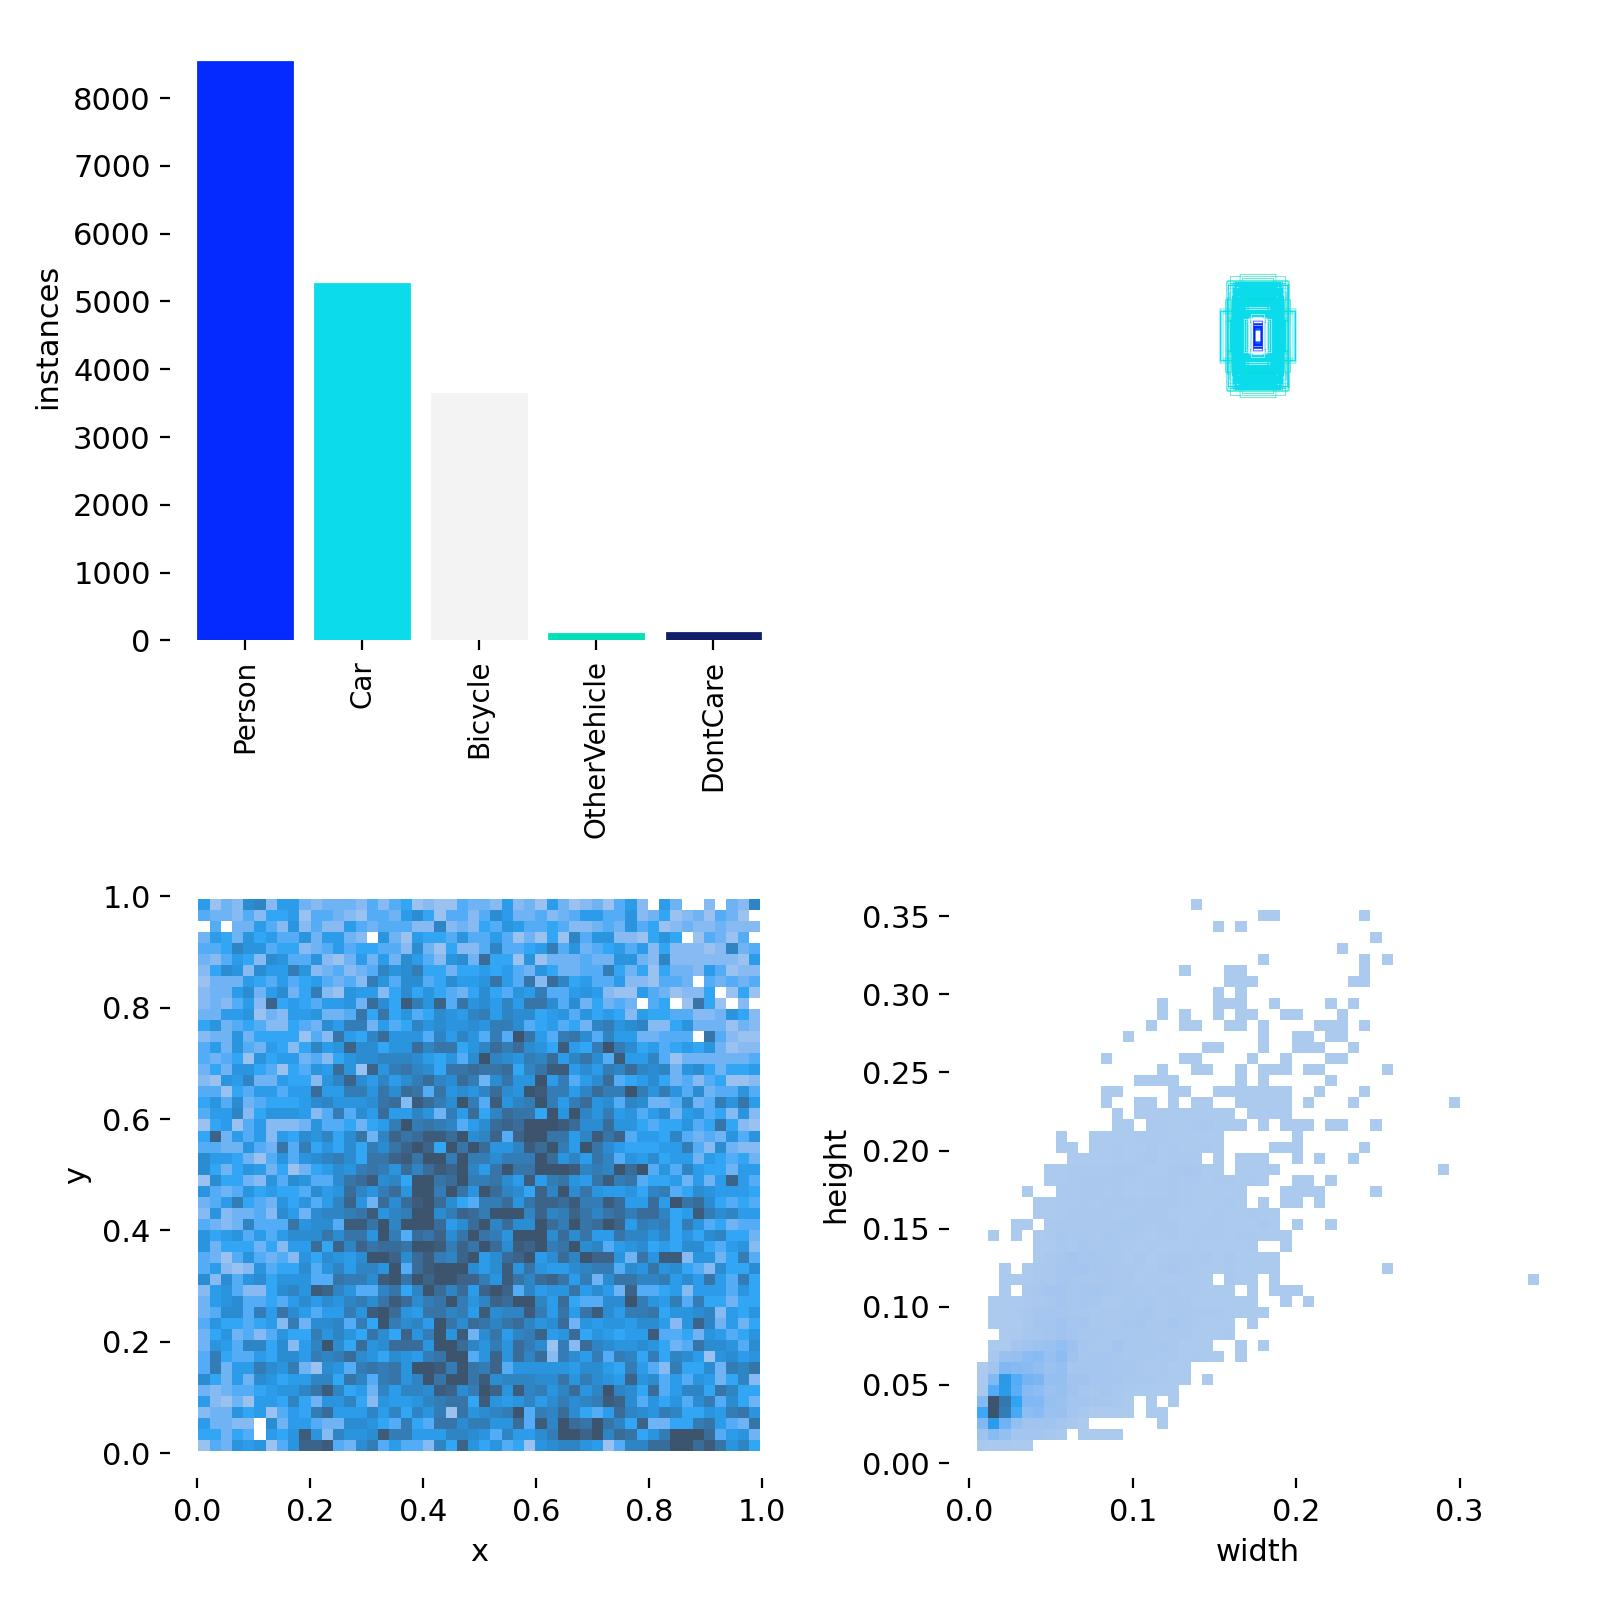


Displaying: labels_correlogram.jpg


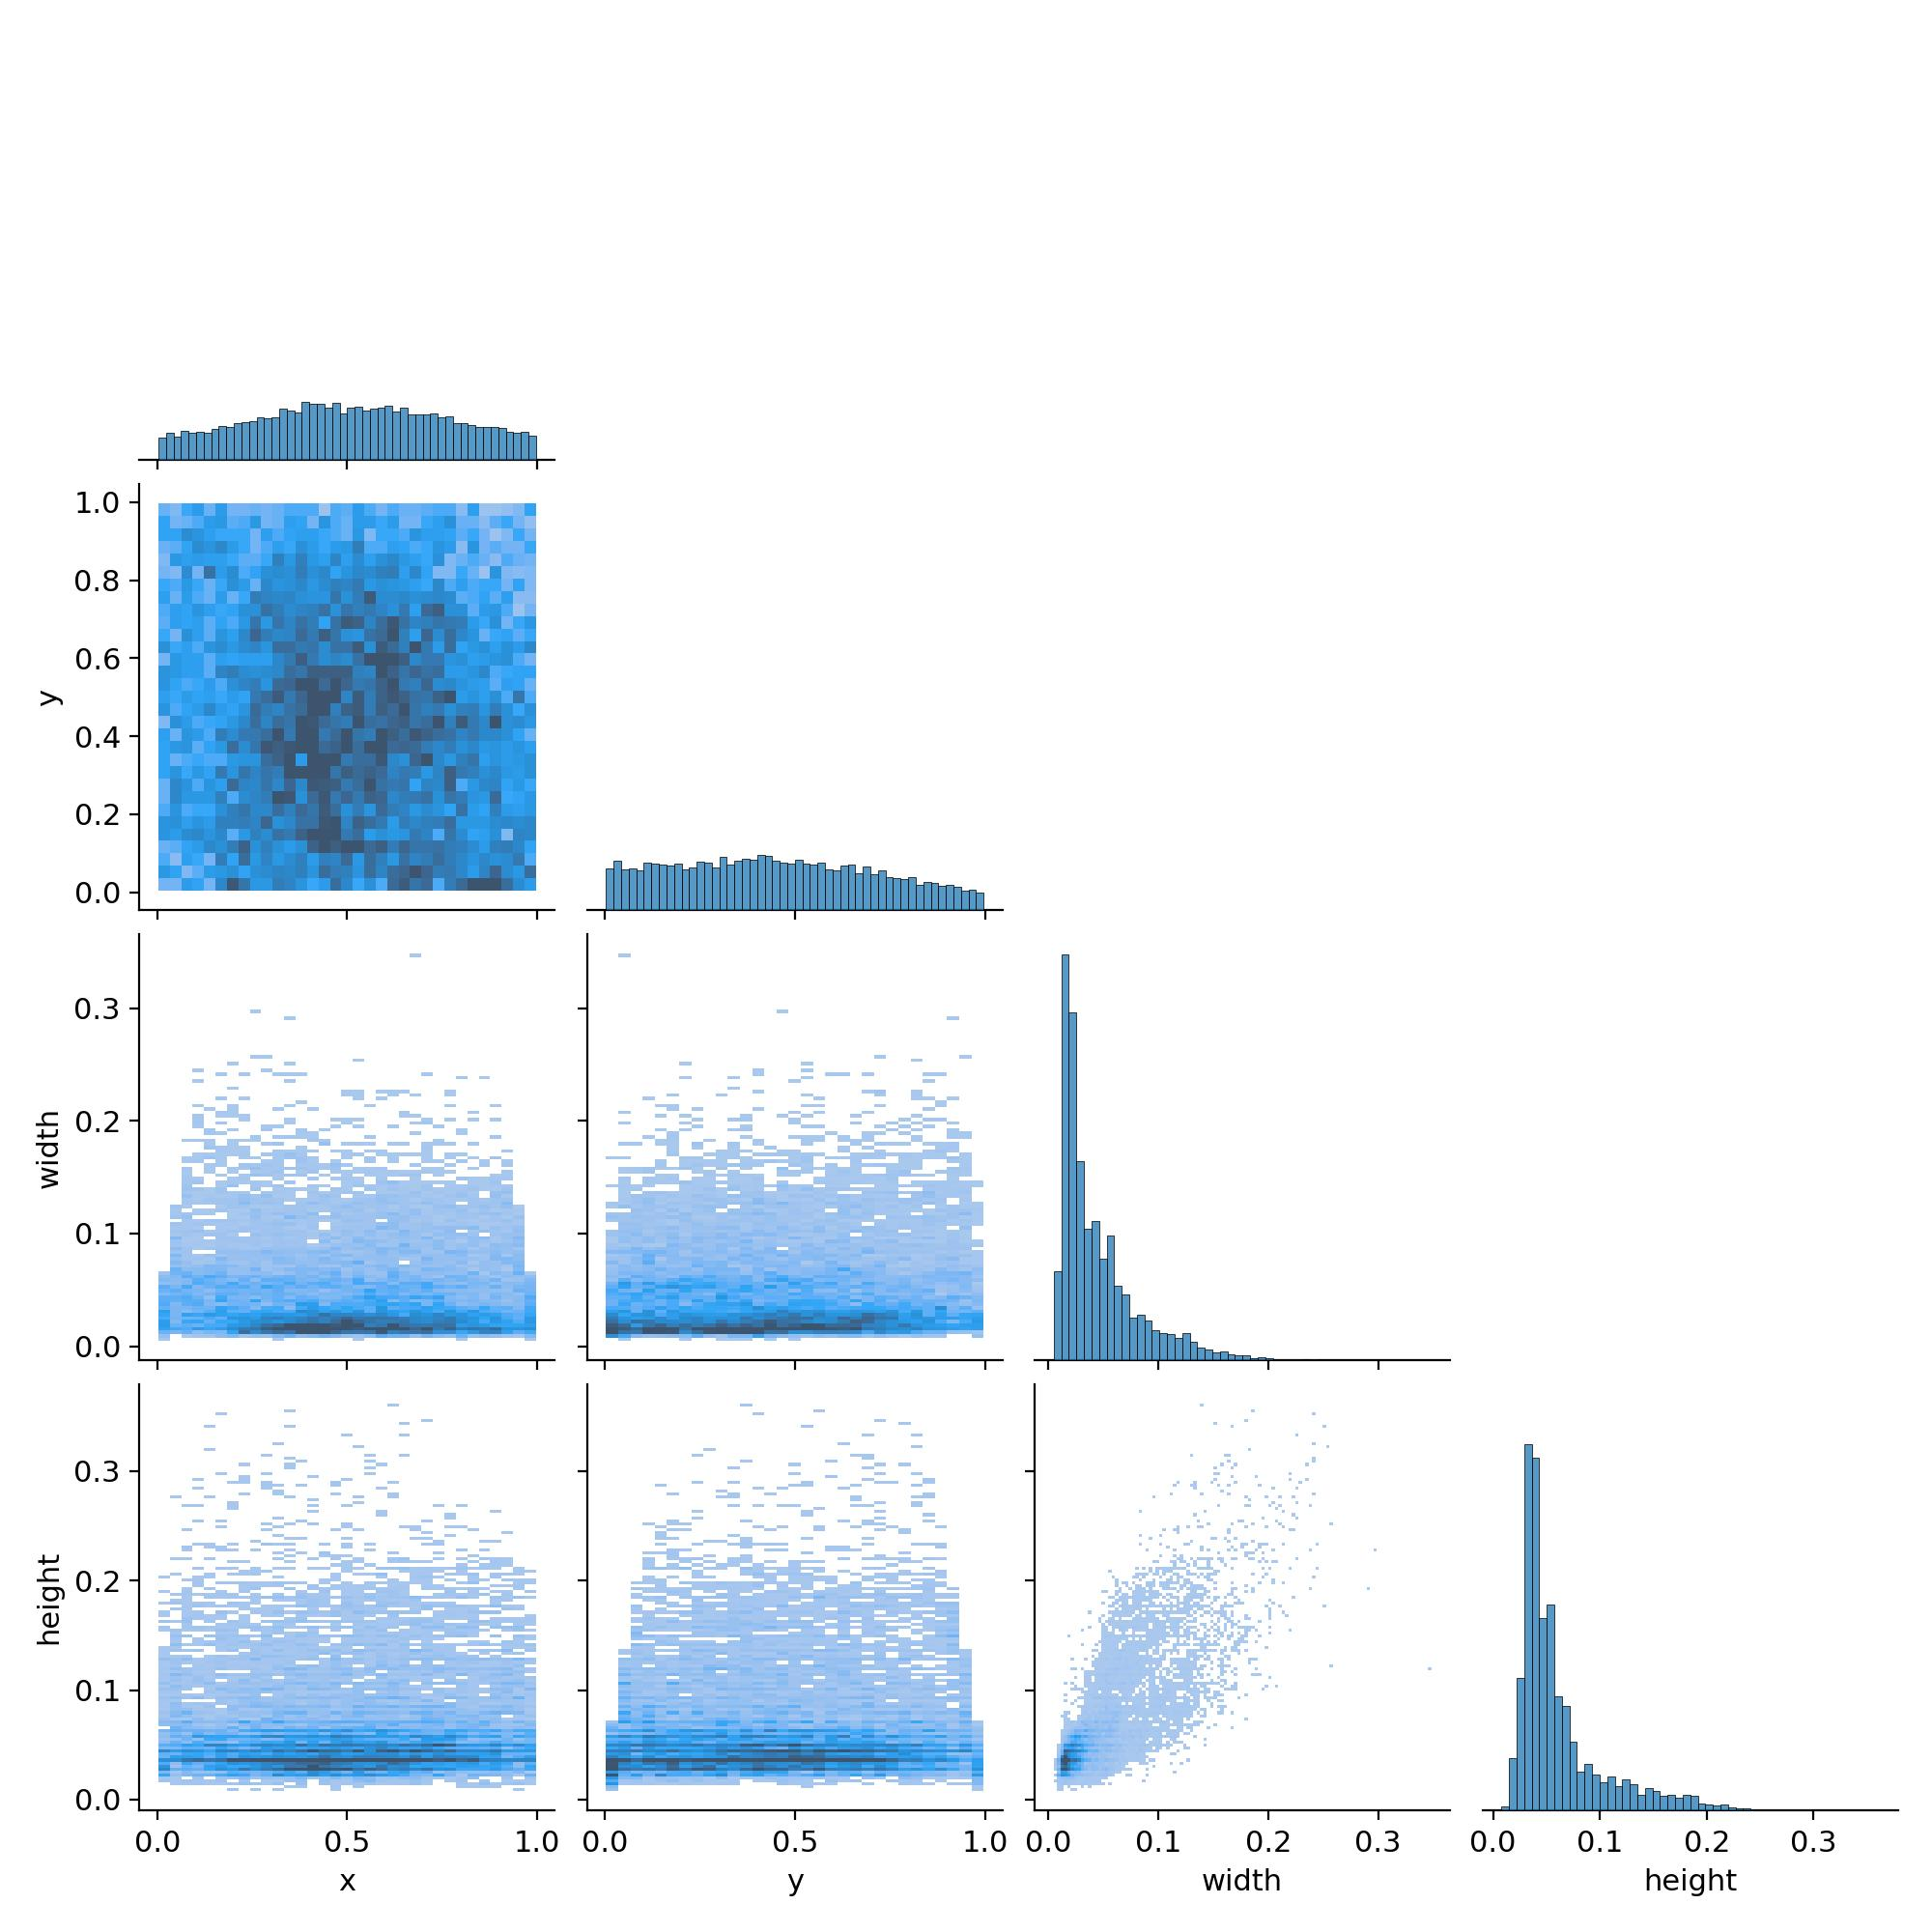


Displaying: results.png


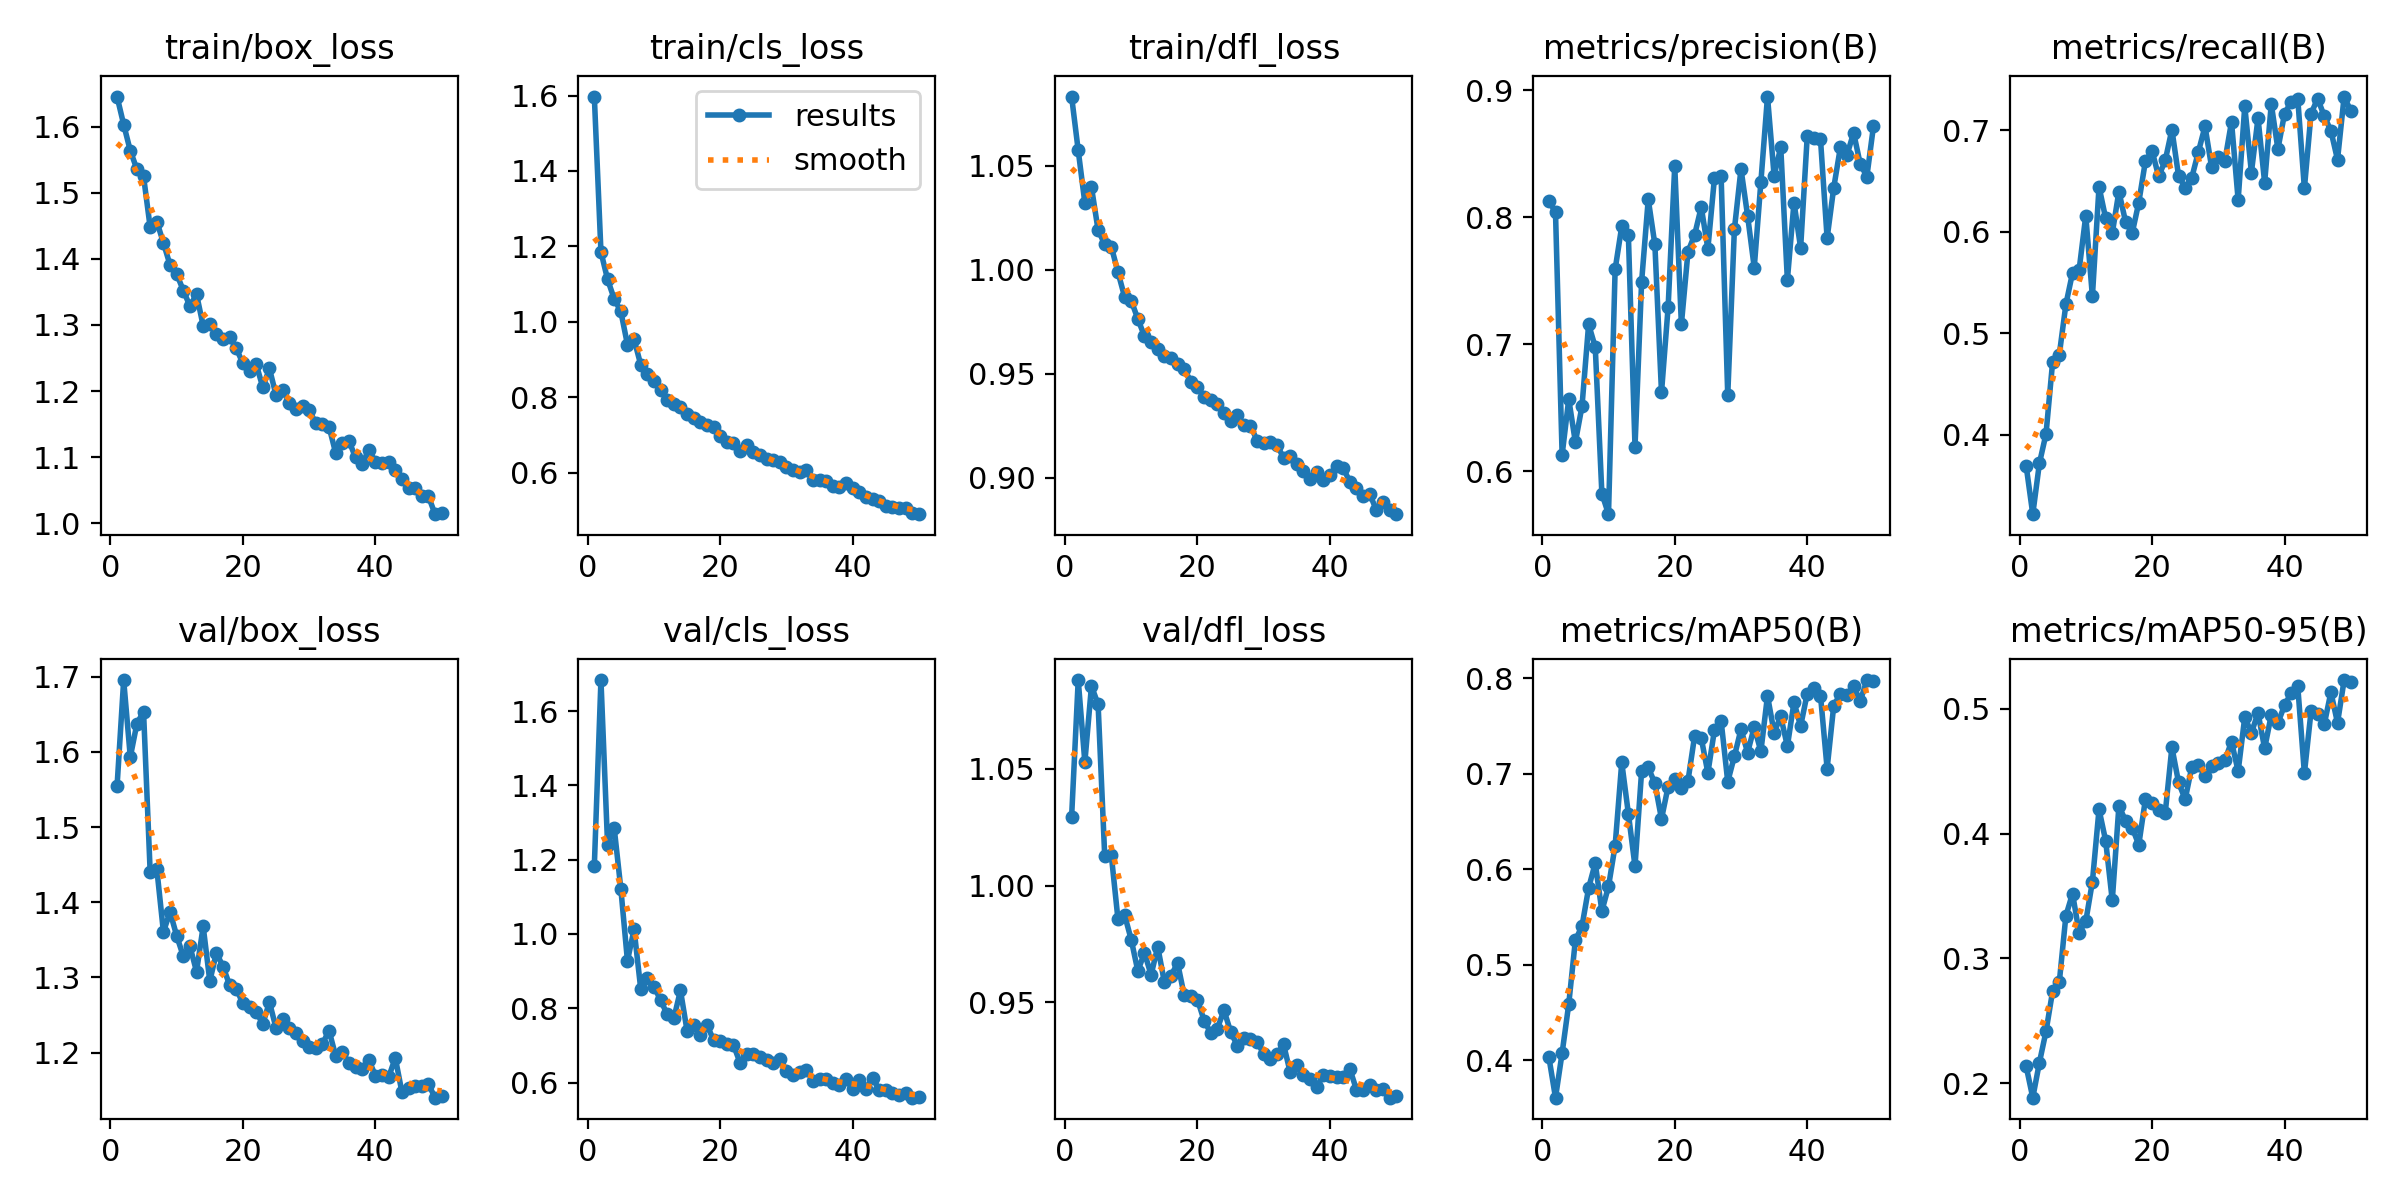


Displaying: training_metrics_plot.png


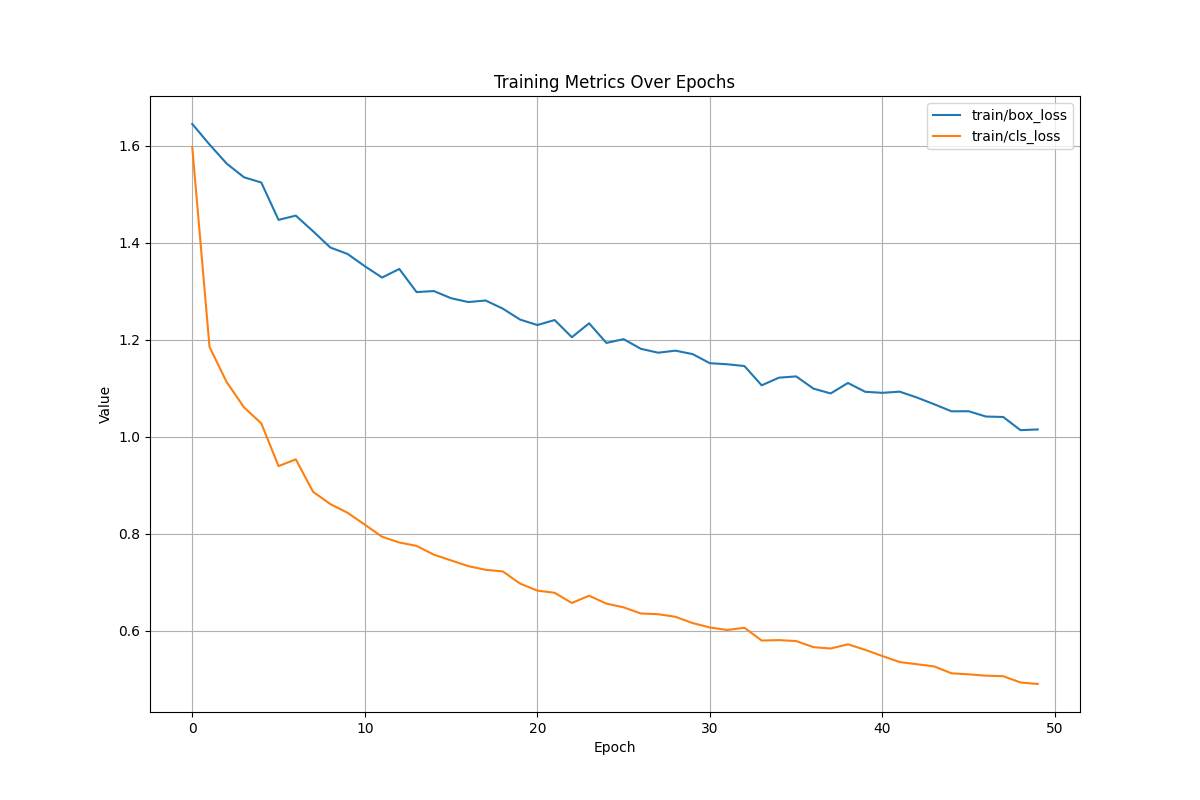

In [5]:
import os
import pandas as pd
from IPython.display import display, Image


results_dir = '/home/adityab/ADRL/runs/detect/yolov5m_custom_training'


results_csv = os.path.join(results_dir, 'results.csv')
if os.path.exists(results_csv):
    print("\nTraining Metrics (CSV):")
    results = pd.read_csv(results_csv)
    print(results.tail())  
else:
    print("Results CSV file not found!")


result_images = [
    'confusion_matrix.png',
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'PR_curve.png',
    'P_curve.png',
    'R_curve.png',
    'labels.jpg',
    'labels_correlogram.jpg',
    'results.png',
    'training_metrics_plot.png',
]

for image_name in result_images:
    image_path = os.path.join(results_dir, image_name)
    if os.path.exists(image_path):
        print(f"\nDisplaying: {image_name}")
        display(Image(filename=image_path))
    else:
        print(f"{image_name} not found!")



image 1/1 /home/adityab/ADRL/A1/hit-uav/images/test/0_60_40_0_06477.jpg: 416x512 3 Cars, 61.1ms
Speed: 1.5ms preprocess, 61.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /home/adityab/ADRL/A1/hit-uav/images/test/1_60_50_0_07429.jpg: 416x512 5 Cars, 4 Bicycles, 7.1ms
Speed: 1.3ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /home/adityab/ADRL/A1/hit-uav/images/test/0_120_50_0_09521.jpg: 416x512 5 Cars, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /home/adityab/ADRL/A1/hit-uav/images/test/1_120_80_0_02983.jpg: 416x512 8 Persons, 7.8ms
Speed: 1.4ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /home/adityab/ADRL/A1/hit-uav/images/test/1_130_40_0_07176.jpg: 416x512 17 Cars, 7.4ms
Speed: 1.2ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 512)

image 1/1 /home/ad

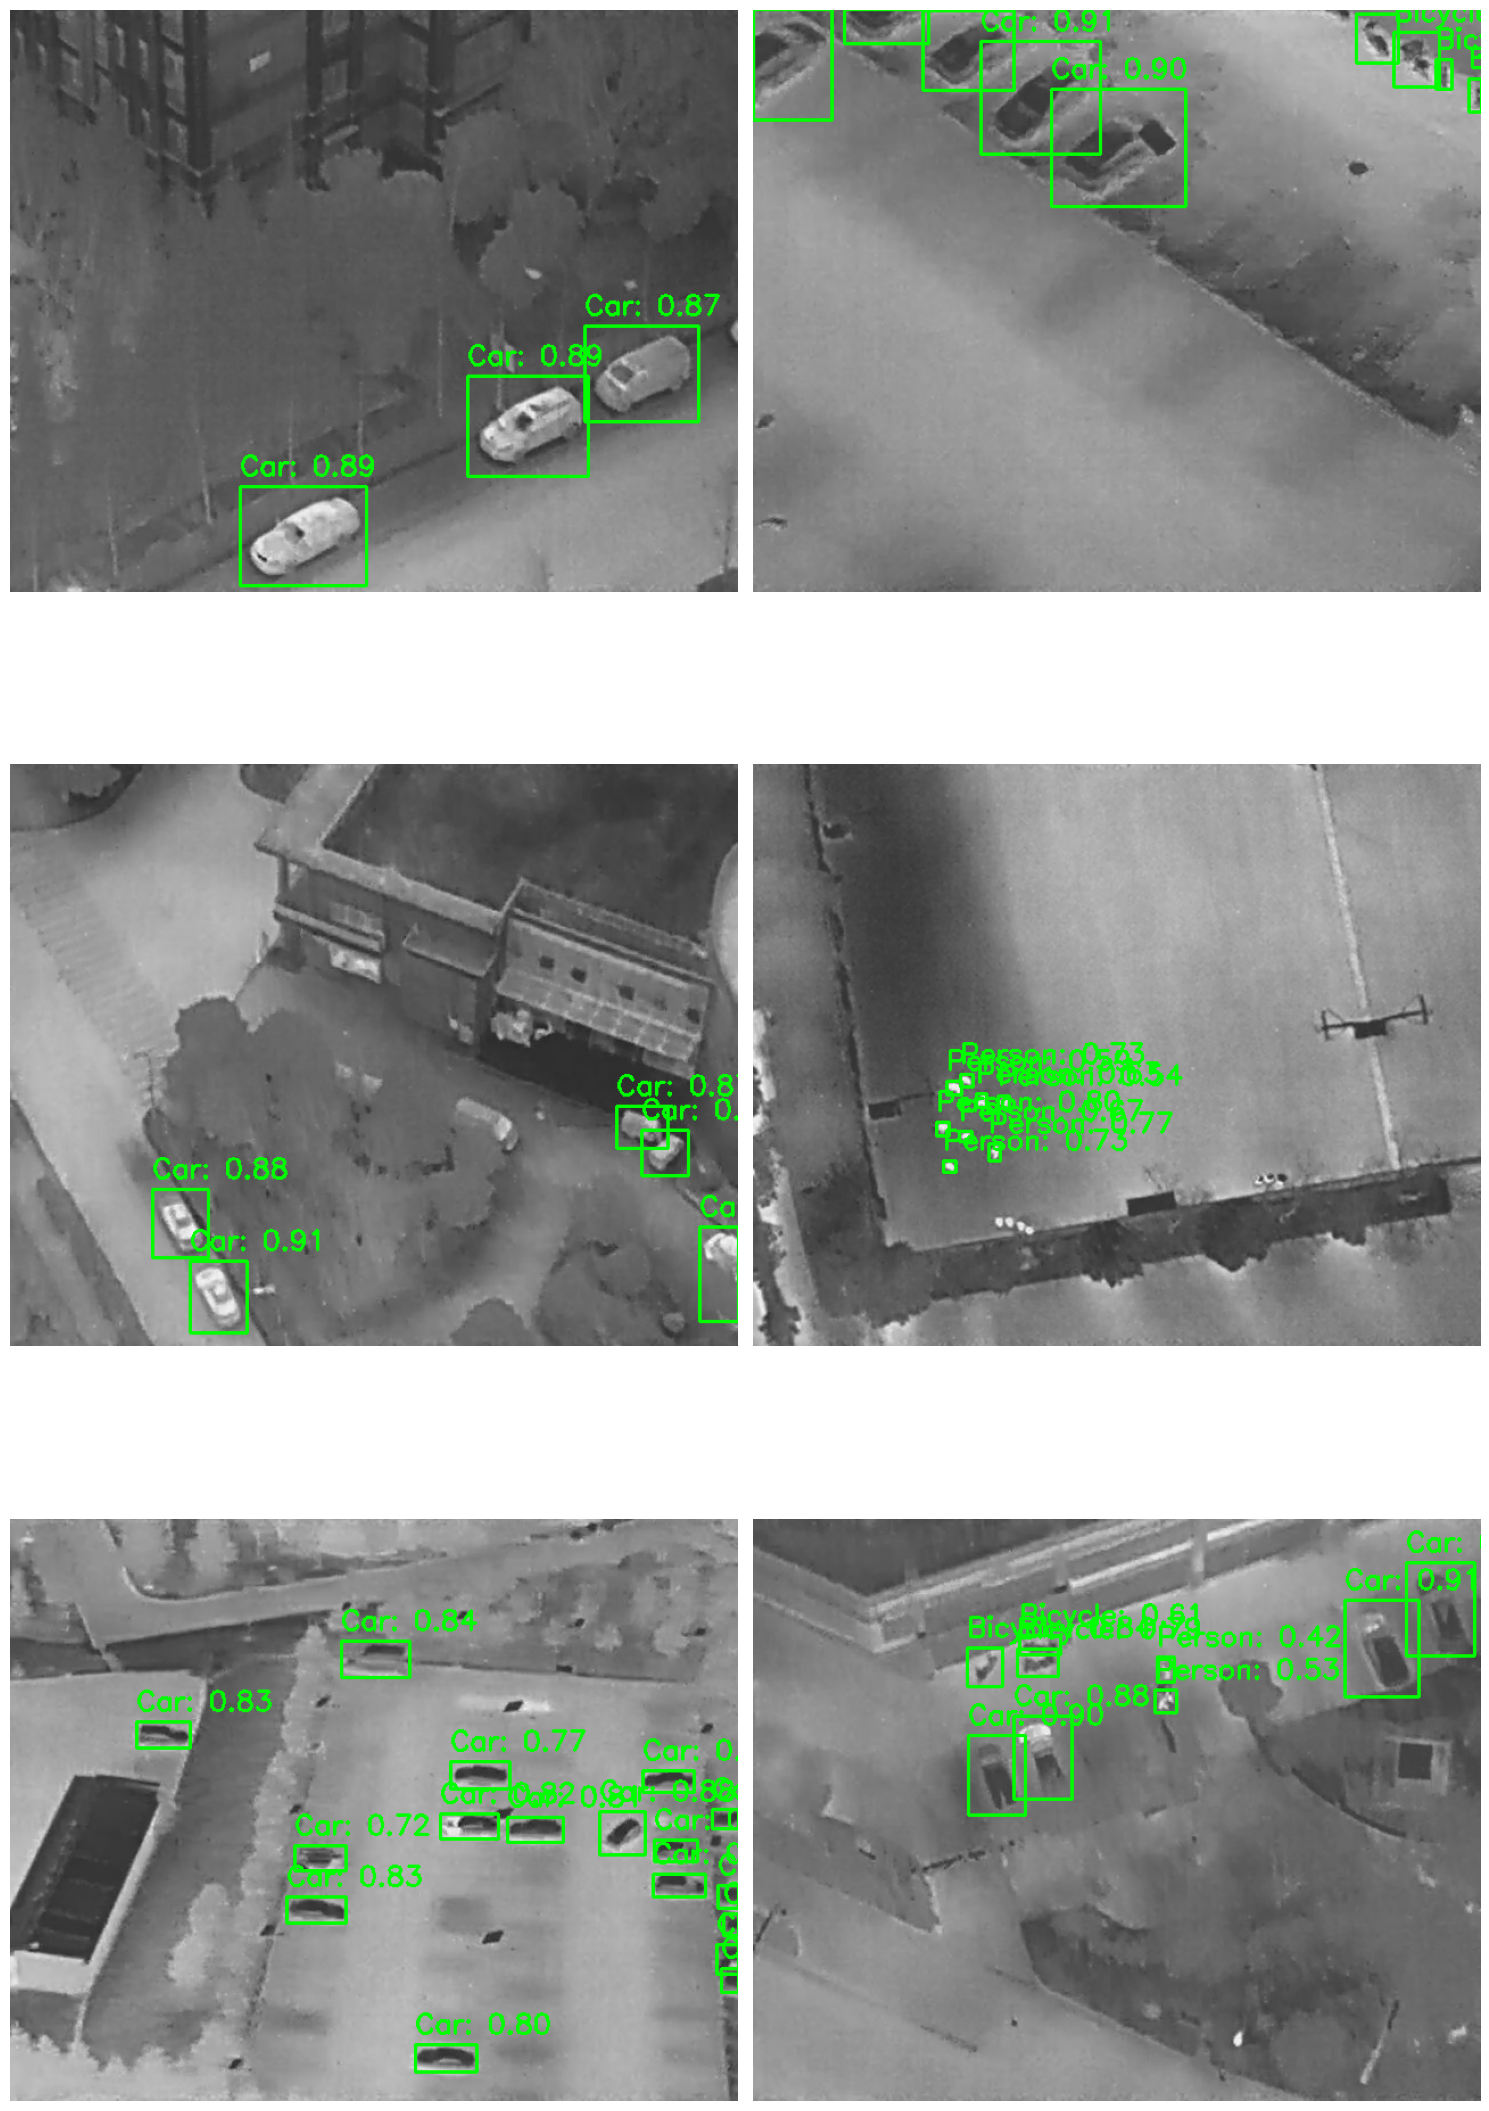

In [6]:
import os
import random
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt


test_images_dir = '/home/adityab/ADRL/A1/hit-uav/images/test'
model_path = '/home/adityab/ADRL/runs/detect/yolov5m_custom_training/weights/best.pt'  # Path to the best model


model = YOLO(model_path)


test_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('.jpg', '.png'))]


num_samples = 6  
sample_images = random.sample(test_images, num_samples)


def plot_predictions(ax, image_path, results, classes):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in results.boxes:
        
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        conf = float(box.conf[0])  
        cls_id = int(box.cls[0])  
        label = f"{classes[cls_id]}: {conf:.2f}"

        
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

        
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    ax.imshow(img)
    ax.axis('off')


num_rows = (num_samples + 1) // 2  


fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 8))  
axes = axes.flatten()  

for i, img_path in enumerate(sample_images):
    results = model(img_path)  
    plot_predictions(axes[i], img_path, results[0], model.names)  


for ax in axes[num_samples:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
